# Abstract:
This study helps in analysing the London Borough of Barnet’s corporate credit card transactions, spanning various datasets from 2014 to 2018. The analysis aims on providing a comprehensive summary into financial activities reflected through the given data with a focus on meeting the requirements of the auditor’s questions. By carefully examining, the study offers a summary view of various transactions aggregated by the Service Area, lubricating differences in transaction counts across quarters and providing relevant statistical scores. Moreover, identifications of significant changes in spending behavior using Service Area and Account to determines inconsistencies in creditor classifications, grouping Service Areas with similar spending patterns, and utilizing anomaly detection techniques for identifying notable transactions. With the help of visualizations using different charts and graphs, the analysis offers significant insightful essentials for auditing and financial oversight.

# Assumptions

- Service Area denotes the functional areas (org chart) within the Borough of Barnett.
- Account Description is the name of the general ledger account in which each transaction is recorded.
- Assume that Journal Date and Transaction Date are synonymous.
- Disregard JV Date.
- Assume Total and JV Value are synonymous; these are the amount of each transaction.

# Auditor Requirements:

1. The Auditor would like to get a summary view of the transactions for each Service Area. The summary view would include at least one visual representation of the transactions in such a way that they could compare them by quarter. Quarters are defined based on the calendar year (Q1 is January to March, Q2 April to June, etc.). The Auditor would also like a summary table with some relevant statistics (The Auditor says something along the lines of “transaction counts and averages”, but welcomes ideas).

2. The Auditor would like to get a view if there are any significant changes in spending behavior by Service Area and by Account. Changes in behavior could be spikes, but could also be permanent increases in the transaction amounts. Please identify instances of both or show that they do not exist in the data.

3. The Auditor would like to get an understanding of how Creditors are classified into accounts. In particular, they are worried about transaction misclassification. Are you able to identify instances in which Creditors are not consistently classified into Accounts (e.g., most of the time Creditor “AirTickets.com” is classified into “Travelling Expenses”, but on some occasions it is also found in “Miscellaneous”)? 

4. In terms of spending behavior (defined by the number and the typical size of transactions), are there Service Areas that behave similarly and can be grouped together? How?

5. The auditor has heard that you may know anomaly detection techniques. They would like to ask you for a sample of a few hundred transactions that are anomalous, different or worthwhile inquiring about.  The sample should include at least five transactions for each Service Area. Please provide this sample and explain why they are special or different.

# Loading External Dependencies

In [70]:
# Data Manipulation.
from pandas import read_csv, DataFrame, concat, to_datetime

# Regular-Expression.
import re

# Visualization.
from matplotlib import pyplot as plt

# Modeling.
from sklearn.ensemble import IsolationForest

# Exploring Data

In [24]:
class Data:

    def __init__(self, paths : list[str]) -> None:

        # Preparing a container for storing the data.
        self.data = list()

        # Iterate over each path of data stored.
        for path in paths:

            # Add data one by one.
            self.data.append(self.load_data(path))

    def load_data(self, path : str) -> DataFrame:
        
        # Loads the data for various `path`s.
        return read_csv(path)
    
    def fix_feature_names(self, new_feature_names : list[dict] = list()) -> None:
        
        # Counter for iterating over the specific dataset in the list.
        iteration = 0
        
        # Iterating over each data to change their feature name.
        for data_features in new_feature_names:
            
            # Replacing the column-names.
            self.data[iteration].rename(data_features, axis = 1, inplace = True)
            
            # Cyling through each iteration.
            iteration += 1
            
    def convert_to_float(self, feature_names : list[str] = list()) -> None:
        
        # Iterating over each dataset.
        for column in self.dataset.columns:
            
            # If the column exist in the feature set provided.
            if column in feature_names:
                
                try:
                    # Convert it to a float instance.
                    self.dataset[column] = self.dataset[column].astype(float)
                    
                except ValueError as ve:

                    # When the value contains commas.
                    if str(ve).__contains__('could not convert string to float'):
                        
                        # Replace those commas with an empty string.
                        self.dataset[column] = self.dataset[column].str.replace(',', '').astype(float)
            
    def convert_to_datetime(self) -> None:
        
        # Iterating over each dataset's column.
        for column in self.dataset.columns:
            
            # If the column name contains a word Date in it.
            if column.__contains__('Date'):
                
                # Convert it to a datetime instance.
                self.dataset[column] = to_datetime(self.dataset[column])
            
    def merge_data(self) -> DataFrame:
        
        # Concatinates each `data`.
        return concat(self.data, ignore_index = True)
    
    # def join_data(self) -> DataFrame:
    #     return 
    
    def get_column_names(self) -> DataFrame:
        
        # Provides a list of column names for each `data`.
        return [data.columns for data in self.data]

## Loading the Data

In [25]:
# Loading the given datasets.
pcd = Data(paths = [
    'Data/Purchasing Card Data 2014 v1.CSV',
    'Data/PCard Transactions 15-16.XSCORE',
    'Data/PCard 1617.CSV',
    'Data/1718Pcard.CSV'
])

# Displaying the data.
pcd.data

[                    Service Area             Account Description  \
 0             Childrens Services                     IT Services   
 1             Childrens Services                  Other Services   
 2             Childrens Services  Equipment and Materials Repair   
 3             Childrens Services  Equipment and Materials Repair   
 4             Childrens Services  Building Repairs & Maintenance   
 ...                          ...                             ...   
 4137      Adults and Communities                         Postage   
 4138  Children's Family Services  Equipment and Materials Purcha   
 4139  Children's Family Services  Equipment and Materials Purcha   
 4140  Children's Family Services           Books-CDs-Audio-Video   
 4141  Children's Family Services  Other Transfer Payments to Soc   
 
                  Creditor Transaction Date  JV Reference     JV Date  JV Value  
 0           123-REG.CO.UK       23/04/2014            93  20/05/2014    143.81  
 1    

In [26]:
pcd.data[0]

,Service Area,Account Description,Creditor,Transaction Date,JV Reference,JV Date,JV Value
0,Childrens Services,IT Services,123-REG.CO.UK,23/04/2014,93,20/05/2014,143.81
1,Childrens Services,Other Services,ACCESS EXPEDITIONS,03/04/2014,111,20/05/2014,"6,000.00"
2,Childrens Services,Equipment and Materials Repair,AFE SERVICELINE,02/04/2014,6,20/05/2014,309.38
3,Childrens Services,Equipment and Materials Repair,AFE SERVICELINE,02/04/2014,7,20/05/2014,218.76
4,Childrens Services,Building Repairs & Maintenance,ALLSOP & FRANCIS,15/04/2014,381,20/05/2014,306
...,...,...,...,...,...,...,...
4137,Adults and Communities,Postage,WWW.ROYALMAIL.COM,23/02/2015,5002,16/03/2015,124
4138,Children's Family Services,Equipment and Materials Purcha,WWW.SMYTHSTOYS.COM,20/02/2015,5188,16/03/2015,89.96
4139,Children's Family Services,Equipment and Materials Purcha,WWW.TTS-GROUPS.CO.U,06/02/2015,5207,16/03/2015,445.92
4140,Children's Family Services,Books-CDs-Audio-Video,WWW.WILDGOOSE.AC,09/02/2015,5271,16/03/2015,407.44


In [27]:
pcd.data[1]

,Service Area,Account Description,Creditor,Journal Date,Journal Reference,Total
0,Assurance,Miscellaneous Expenses,43033820 COSTA COFFEE,18/08/2015,5043.0,2
1,Children's Family Services,Miscellaneous Expenses,99 PLUS DISCOUNT MART,08/06/2015,4184.0,29.97
2,Children's Family Services,E19 - Learning Resources,99P STORES LTD,07/12/2015,6278.0,34.65
3,Children's Family Services,Equipment and Materials Purcha,99P STORES LTD,18/08/2015,5041.0,10.72
4,Children's Family Services,Subsistence,CHOPSTIX00000000000,21/05/2015,5750.0,33.7
...,...,...,...,...,...,...
3860,Children's Family Services,Food Costs,ZAHRA NEWSAGENT,17/11/2015,6042.0,3.5
3861,Children's Family Services,Food Costs,ZAHRA NEWSAGENT,20/01/2016,6751.0,4.5
3862,Children's Family Services,Food Costs,ZAHRA NEWSAGENT,21/03/2016,7535.0,4.5
3863,Children's Family Services,Food Costs,ZAHRA NEWSAGENT,31/03/2016,7639.0,4.5


In [28]:
pcd.data[2]

,Service Area,Account Description,Creditor,Journal Date,Journal Reference,Total
0,Adults and Communities,Books-CDs-Audio-Video,AMAZON EU,05/12/2016,10510.0,45.00
1,Adults and Communities,Books-CDs-Audio-Video,AMAZON UK MARKETPLACE,05/12/2016,10509.0,426.57
2,Adults and Communities,Books-CDs-Audio-Video,AMAZON UK RETAIL AMAZO,06/12/2016,10524.0,121.38
3,Adults and Communities,Consumable Catering Supplies,WWW.ARGOS.CO.UK,01/03/2017,11667.0,78.94
4,Adults and Communities,CSG - IT,AMAZON UK MARKETPLACE,01/02/2017,10974.0,97.50
...,...,...,...,...,...,...
4577,Streetscene,Vehicle Running Costs,WWW.DVLA.GOV.UK,23/08/2016,9212.0,232.50
4578,Streetscene,Vehicle Running Costs,WWW.DVLA.GOV.UK,23/08/2016,9213.0,167.50
4579,Streetscene,Vehicle Running Costs,WWW.DVLA.GOV.UK,25/08/2016,9248.0,232.50
4580,Streetscene,Vehicle Running Costs,WWW.MOT-TESTING-CP,25/11/2016,10384.0,68.00


In [29]:
pcd.data[3]

,FIN.TRANSACTION DATE,FIN.POSTING DATE,FIN.TRANSACTION AMOUNT,MCH.MERCHANT NAME,MCH.CITY NAME,FIN.ORIGINAL CURRENCY AMOUNT,FIN.ORIGINAL ISO CURRENCY CODE SYMBOL,FIN.INET CONVERSION
0,06/04/17,07/04/17,36.55,TESCO STORE 2296,COLNEY HATCH,36.55,GBP,1.0
1,06/04/17,07/04/17,58.75,AMFBOWLING.CO.UK,01442 840200,58.75,GBP,1.0
2,10/04/17,11/04/17,40.50,WWW.GOJUMPIN.COM,INTERNET,40.50,GBP,1.0
3,12/04/17,13/04/17,23.90,AMFBOWLING.CO.UK,01442 840200,23.90,GBP,1.0
4,12/04/17,13/04/17,24.28,VUE BSL LTD,LONDON,24.28,GBP,1.0
...,...,...,...,...,...,...,...,...
4926,16/03/18,19/03/18,20.00,GIFFGAFF,WWW.GIFFGAFF,20.00,GBP,1.0
4927,07/03/18,08/03/18,354.25,LOVE2SHOP.CO.UK,0345 717 1111,354.25,GBP,1.0
4928,21/03/18,22/03/18,51.88,AMAZON UK MARKETPLACE,800-279-6620,51.88,GBP,1.0
4929,22/03/18,26/03/18,10.00,WWW.BRENTGOV.UK,INTERNET,10.00,GBP,1.0


- Considering the second and third dataset's last row, the record contains nothing but a sum of column-values.
- Hence, we can drop that record without any hesitation.

### Validating its features-name.

In [30]:
# Displaying Columns for Each Dataset.
pcd.get_column_names()

[Index(['Service Area', 'Account Description', 'Creditor', 'Transaction Date',
        'JV Reference', 'JV Date', 'JV Value'],
       dtype='object'),
 Index(['Service Area', 'Account Description', 'Creditor', 'Journal Date',
        'Journal Reference', 'Total'],
       dtype='object'),
 Index(['Service Area', 'Account Description', 'Creditor', 'Journal Date',
        'Journal Reference', 'Total'],
       dtype='object'),
 Index(['FIN.TRANSACTION DATE', 'FIN.POSTING DATE', 'FIN.TRANSACTION AMOUNT',
        'MCH.MERCHANT NAME', 'MCH.CITY NAME', 'FIN.ORIGINAL CURRENCY AMOUNT',
        'FIN.ORIGINAL ISO CURRENCY CODE SYMBOL', 'FIN.INET CONVERSION'],
       dtype='object')]

- As we can determine that the given columns are similar but their names are different.
- So, we need to change their name and bring consistency.

### Bringing Feature-Name Consistency

In [31]:
# Changing column names.
pcd.fix_feature_names(new_feature_names = [

    # 2014:
    {
        'JV Reference' : 'Journal Reference',
        'JV Value' : 'Total'
    },
    
    # 2015-16:
    {
        'Journal Date' : 'Transaction Date'
    },
    
    # 2016:
    {
        'Journal Date' : 'Transaction Date'
    },
    
    # 2017-18:
    { field : re.sub(pattern = r'(.*)\.(\w+) (\w+)', repl = r'\2 \3', string = field).title() for field in pcd.data[3].columns }
])

# Displaying Columns for Each Dataset.
pcd.get_column_names()

[Index(['Service Area', 'Account Description', 'Creditor', 'Transaction Date',
        'Journal Reference', 'JV Date', 'Total'],
       dtype='object'),
 Index(['Service Area', 'Account Description', 'Creditor', 'Transaction Date',
        'Journal Reference', 'Total'],
       dtype='object'),
 Index(['Service Area', 'Account Description', 'Creditor', 'Transaction Date',
        'Journal Reference', 'Total'],
       dtype='object'),
 Index(['Transaction Date', 'Posting Date', 'Transaction Amount',
        'Merchant Name', 'City Name', 'Original Currency Amount',
        'Original Iso Currency Code Symbol', 'Inet Conversion'],
       dtype='object')]

<h3>Assumptions:</h3>

- `Merchant Name` is `Creditor`.
- `Posting Date` is `Journal Date`.

In [32]:
# Manually fixing the feature-name missed in the first trail of complex operation.
pcd.data[3].rename({
    'Merchant Name' : 'Creditor',
    'Posting Date' : 'Journal Date',
    'Transaction Amount' : 'Total'
}, axis = 1, inplace = True)

pcd.data[3].columns

Index(['Transaction Date', 'Journal Date', 'Total', 'Creditor', 'City Name',
       'Original Currency Amount', 'Original Iso Currency Code Symbol',
       'Inet Conversion'],
      dtype='object')

In [33]:
# Keeping columns for analysis and removing remaining features.
pcd.data[3] = pcd.data[3][['Creditor', 'Transaction Date', 'Total']]
pcd.data[3]

,Creditor,Transaction Date,Total
0,TESCO STORE 2296,06/04/17,36.55
1,AMFBOWLING.CO.UK,06/04/17,58.75
2,WWW.GOJUMPIN.COM,10/04/17,40.50
3,AMFBOWLING.CO.UK,12/04/17,23.90
4,VUE BSL LTD,12/04/17,24.28
...,...,...,...
4926,GIFFGAFF,16/03/18,20.00
4927,LOVE2SHOP.CO.UK,07/03/18,354.25
4928,AMAZON UK MARKETPLACE,21/03/18,51.88
4929,WWW.BRENTGOV.UK,22/03/18,10.00


In [34]:
# Disregarding JV Date.
pcd.data[0].drop('JV Date', axis = 1, inplace = True)
pcd.data[0]

,Service Area,Account Description,Creditor,Transaction Date,Journal Reference,Total
0,Childrens Services,IT Services,123-REG.CO.UK,23/04/2014,93,143.81
1,Childrens Services,Other Services,ACCESS EXPEDITIONS,03/04/2014,111,"6,000.00"
2,Childrens Services,Equipment and Materials Repair,AFE SERVICELINE,02/04/2014,6,309.38
3,Childrens Services,Equipment and Materials Repair,AFE SERVICELINE,02/04/2014,7,218.76
4,Childrens Services,Building Repairs & Maintenance,ALLSOP & FRANCIS,15/04/2014,381,306
...,...,...,...,...,...,...
4137,Adults and Communities,Postage,WWW.ROYALMAIL.COM,23/02/2015,5002,124
4138,Children's Family Services,Equipment and Materials Purcha,WWW.SMYTHSTOYS.COM,20/02/2015,5188,89.96
4139,Children's Family Services,Equipment and Materials Purcha,WWW.TTS-GROUPS.CO.U,06/02/2015,5207,445.92
4140,Children's Family Services,Books-CDs-Audio-Video,WWW.WILDGOOSE.AC,09/02/2015,5271,407.44


### Combining Dataset.

In [35]:
pcd.dataset = pcd.merge_data()
pcd.dataset

,Service Area,Account Description,Creditor,Transaction Date,Journal Reference,Total
0,Childrens Services,IT Services,123-REG.CO.UK,23/04/2014,93.0,143.81
1,Childrens Services,Other Services,ACCESS EXPEDITIONS,03/04/2014,111.0,"6,000.00"
2,Childrens Services,Equipment and Materials Repair,AFE SERVICELINE,02/04/2014,6.0,309.38
3,Childrens Services,Equipment and Materials Repair,AFE SERVICELINE,02/04/2014,7.0,218.76
4,Childrens Services,Building Repairs & Maintenance,ALLSOP & FRANCIS,15/04/2014,381.0,306
...,...,...,...,...,...,...
17515,NaN,NaN,GIFFGAFF,16/03/18,NaN,20.00
17516,NaN,NaN,LOVE2SHOP.CO.UK,07/03/18,NaN,354.25
17517,NaN,NaN,AMAZON UK MARKETPLACE,21/03/18,NaN,51.88
17518,NaN,NaN,WWW.BRENTGOV.UK,22/03/18,NaN,10.00


### Fixing Datatypes of Fields - Datetime:

In [36]:
# Converting the given dates from object to datetime.
pcd.convert_to_datetime()
pcd.dataset

C:\Users\Ratch\AppData\Local\Temp\ipykernel_24808\1613376842.py:62: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  self.dataset[column] = to_datetime(self.dataset[column])


,Service Area,Account Description,Creditor,Transaction Date,Journal Reference,Total
0,Childrens Services,IT Services,123-REG.CO.UK,2014-04-23,93.0,143.81
1,Childrens Services,Other Services,ACCESS EXPEDITIONS,2014-03-04,111.0,"6,000.00"
2,Childrens Services,Equipment and Materials Repair,AFE SERVICELINE,2014-02-04,6.0,309.38
3,Childrens Services,Equipment and Materials Repair,AFE SERVICELINE,2014-02-04,7.0,218.76
4,Childrens Services,Building Repairs & Maintenance,ALLSOP & FRANCIS,2014-04-15,381.0,306
...,...,...,...,...,...,...
17515,NaN,NaN,GIFFGAFF,2018-03-16,NaN,20.00
17516,NaN,NaN,LOVE2SHOP.CO.UK,2018-07-03,NaN,354.25
17517,NaN,NaN,AMAZON UK MARKETPLACE,2018-03-21,NaN,51.88
17518,NaN,NaN,WWW.BRENTGOV.UK,2018-03-22,NaN,10.00


### Fixing Datatypes of Fields - Float:

In [37]:
# Converting string fields into float.
pcd.convert_to_float(feature_names = [
    'Total',
    'Journal Reference'
])

pcd.dataset

,Service Area,Account Description,Creditor,Transaction Date,Journal Reference,Total
0,Childrens Services,IT Services,123-REG.CO.UK,2014-04-23,93.0,143.81
1,Childrens Services,Other Services,ACCESS EXPEDITIONS,2014-03-04,111.0,6000.00
2,Childrens Services,Equipment and Materials Repair,AFE SERVICELINE,2014-02-04,6.0,309.38
3,Childrens Services,Equipment and Materials Repair,AFE SERVICELINE,2014-02-04,7.0,218.76
4,Childrens Services,Building Repairs & Maintenance,ALLSOP & FRANCIS,2014-04-15,381.0,306.00
...,...,...,...,...,...,...
17515,NaN,NaN,GIFFGAFF,2018-03-16,NaN,20.00
17516,NaN,NaN,LOVE2SHOP.CO.UK,2018-07-03,NaN,354.25
17517,NaN,NaN,AMAZON UK MARKETPLACE,2018-03-21,NaN,51.88
17518,NaN,NaN,WWW.BRENTGOV.UK,2018-03-22,NaN,10.00


In [38]:
# Validating Datatypes.
pcd.dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Service Area         12588 non-null  object        
 1   Account Description  12587 non-null  object        
 2   Creditor             17518 non-null  object        
 3   Transaction Date     17518 non-null  datetime64[ns]
 4   Journal Reference    12587 non-null  float64       
 5   Total                17520 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 821.4+ KB


# Data Preparation

In [39]:
# Quarter of Transaction Date.
pcd.dataset['quarter'] = pcd.dataset['Transaction Date'].dt.to_period('Q').dropna()
pcd.dataset.quarter

0        2014Q2
1        2014Q1
2        2014Q1
3        2014Q1
4        2014Q2
          ...  
17515    2018Q1
17516    2018Q3
17517    2018Q1
17518    2018Q1
17519    2018Q1
Name: quarter, Length: 17520, dtype: period[Q-DEC]

# Data Visualization

## 1. Summary of Transaction Date with Service Area.
The Auditor would like to get a summary view of the transactions for each Service Area. The summary view would include at least one visual representation of the transactions in such a way that they could compare them by quarter. Quarters are defined based on the calendar year (Q1 is January to March, Q2 April to June, etc.). The Auditor would also like a summary table with some relevant statistics (The Auditor says something along the lines of “transaction counts and averages”, but welcomes ideas).

In [56]:
# Grouping Service Area for each Quarter based on Transaction Date.
transactions = pcd.dataset.groupby(['Service Area', 'quarter']).agg(
    total_count = ('Total', 'count'),
    total_mean = ('Total', 'mean')
).reset_index()

transactions

,Service Area,quarter,total_count,total_mean
0,Adults and Communities,2014Q1,2,225.500000
1,Adults and Communities,2014Q2,15,287.430000
2,Adults and Communities,2014Q3,11,228.545455
3,Adults and Communities,2014Q4,14,146.523571
4,Adults and Communities,2015Q1,7,58.554286
...,...,...,...,...
167,Streetscene,2016Q3,69,161.707681
168,Streetscene,2016Q4,50,109.860800
169,Streetscene,2017Q1,38,157.985789
170,Streetscene,2017Q2,2,60.240000


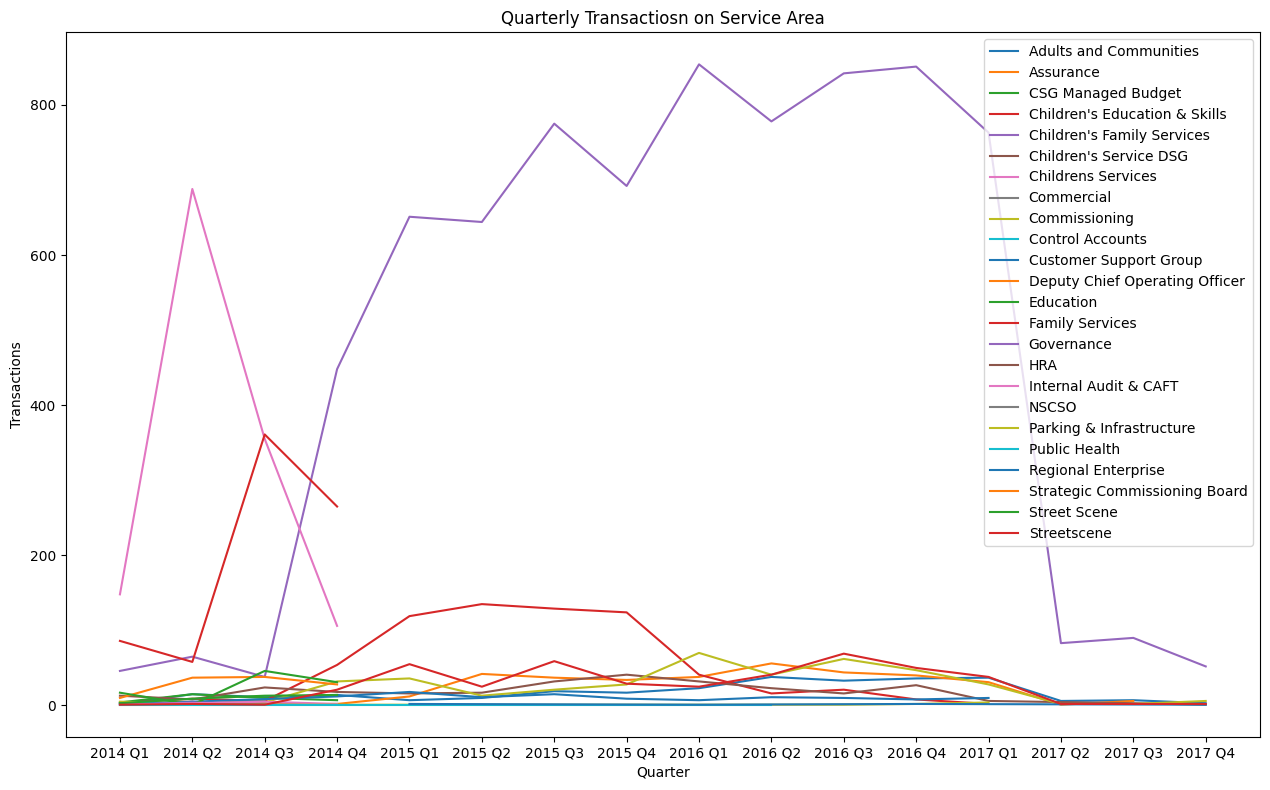

In [57]:
# Chart Resolution: 1280 x 800p
plt.figure(figsize = (12.8, 8))

# Creating a visualization.
for areas in transactions['Service Area'].unique():
    areas_data = transactions[transactions['Service Area'] == areas]
    quarters = [areas_data.quarter]
    plt.plot([quarter.strftime('%Y Q%q') for quarter in areas_data.quarter], areas_data.total_count, label = areas)
    
# Chart Decoration.
plt.legend()

plt.xlabel('Quarter')
plt.ylabel('Transactions')

plt.title('Quarterly Transactiosn on Service Area')

# Improving Layout.
plt.tight_layout()

# Display the Chart.
plt.show()

### Trendy Bar Chart

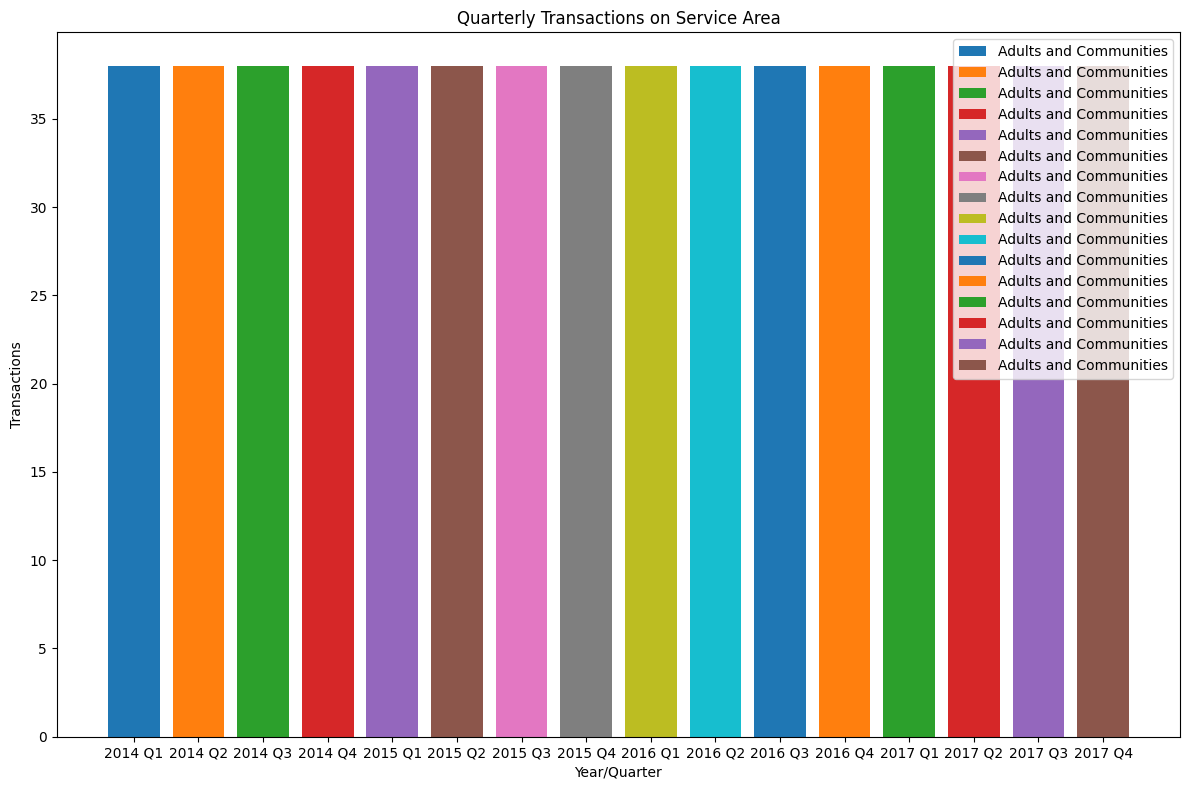

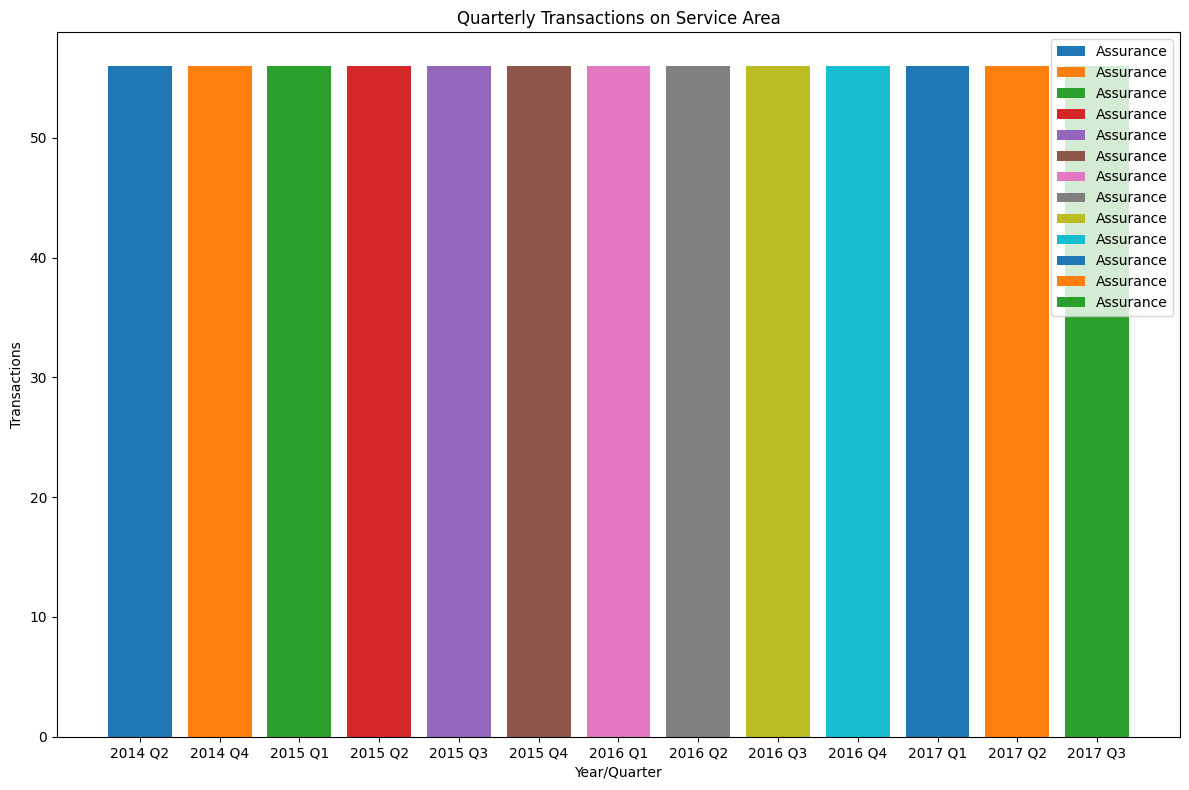

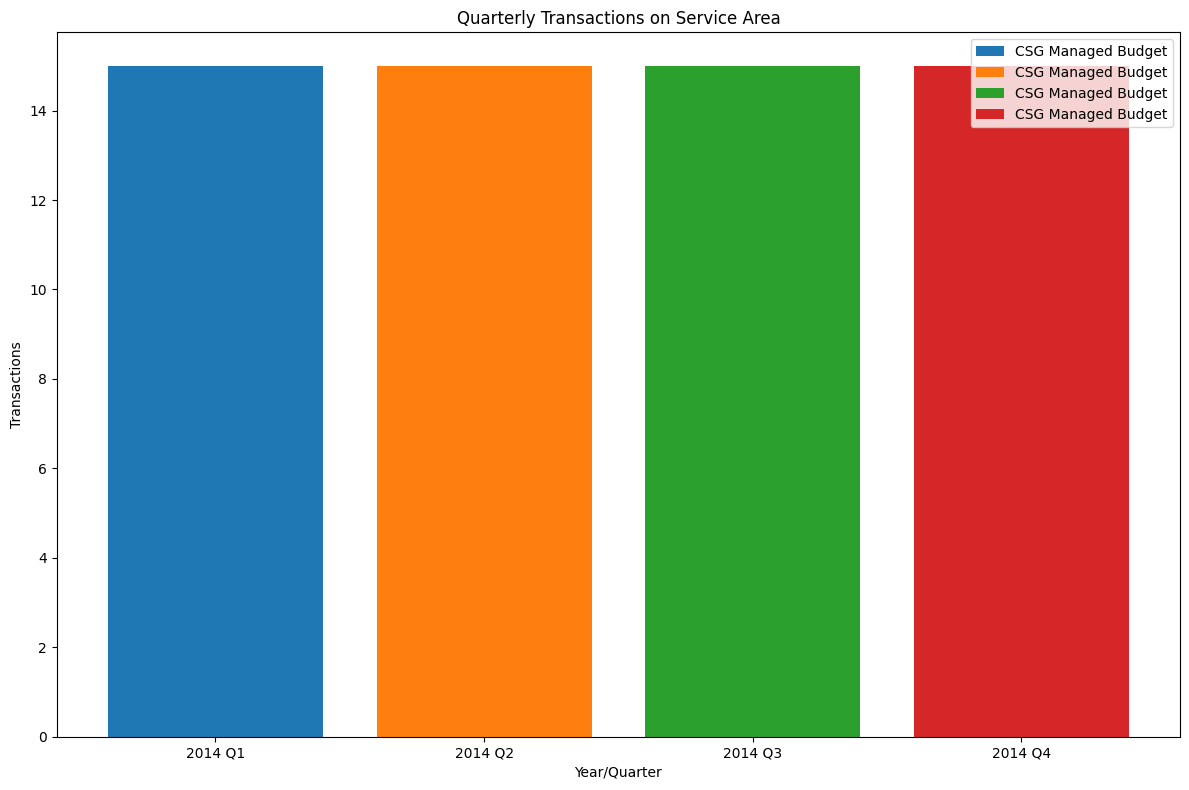

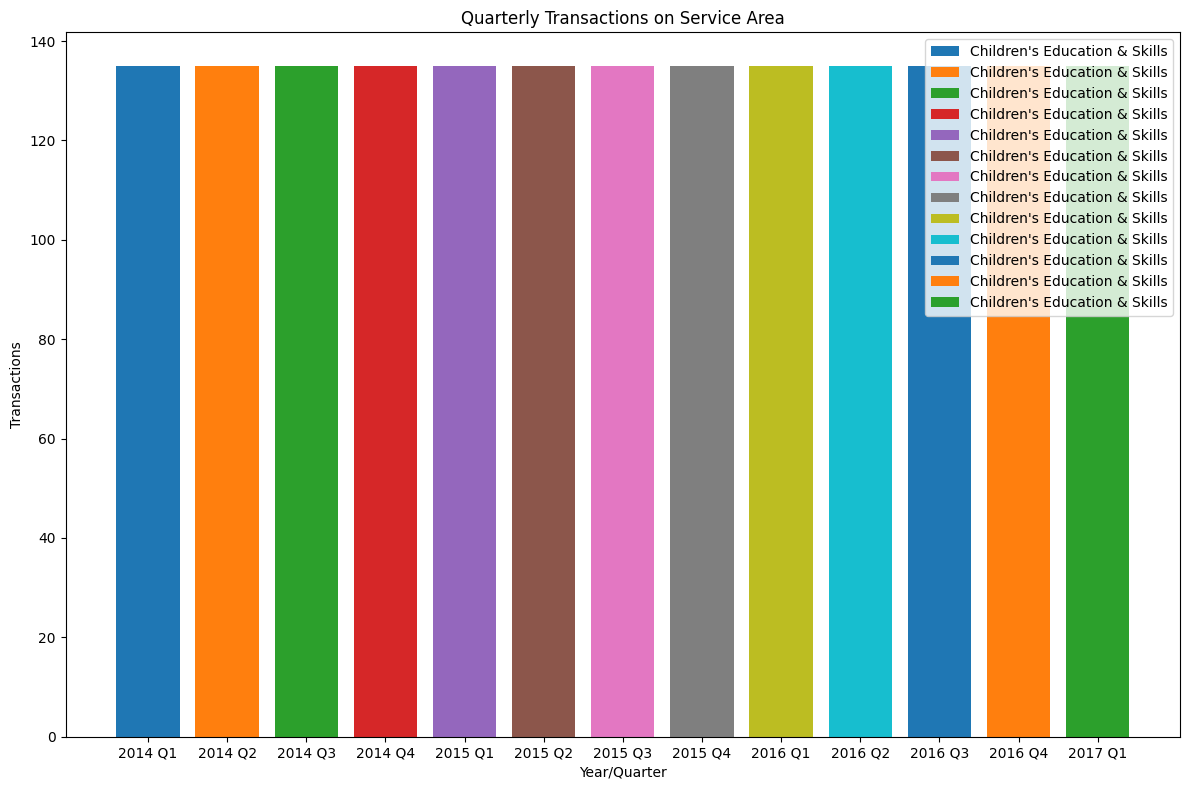

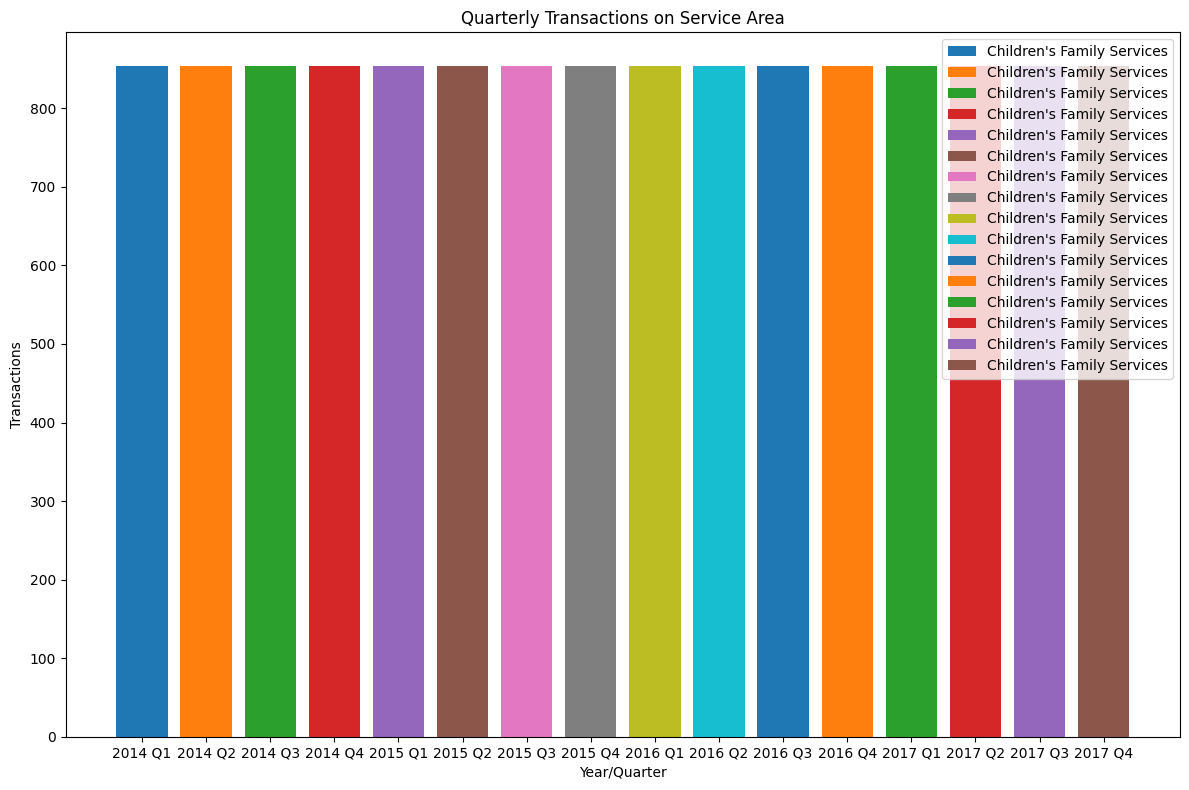

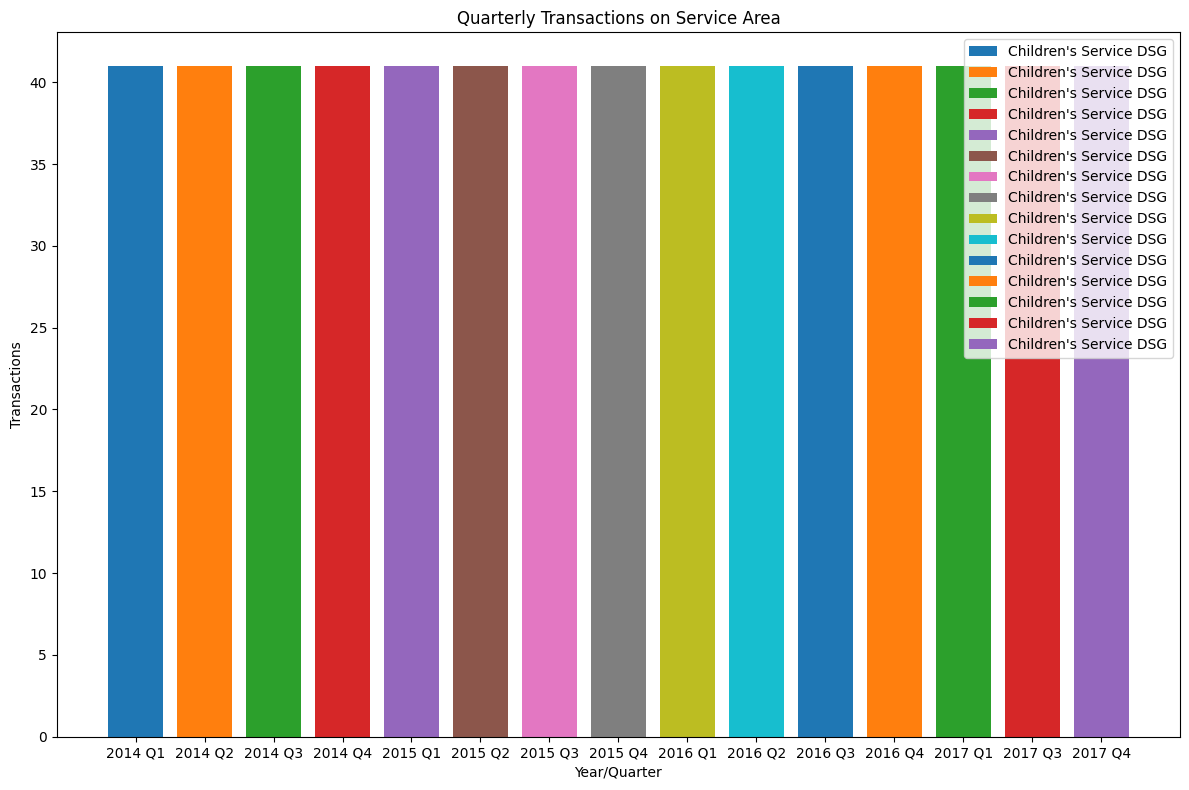

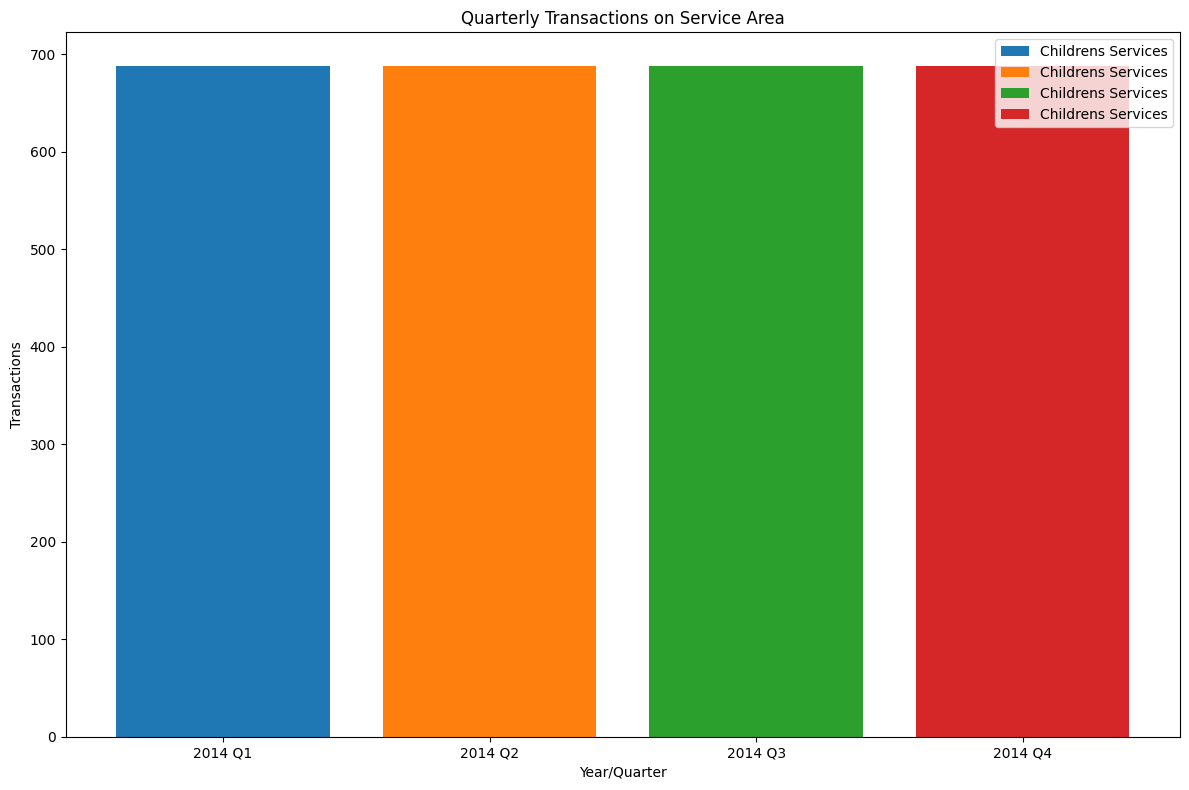

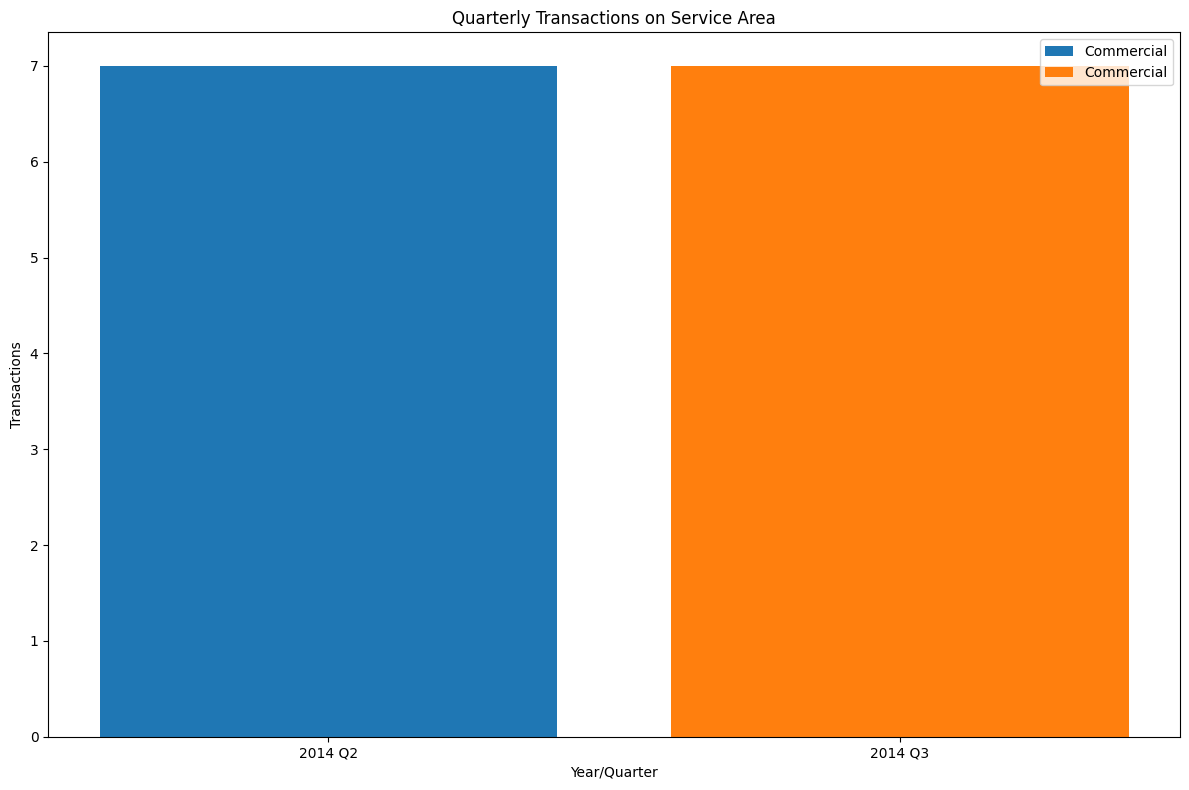

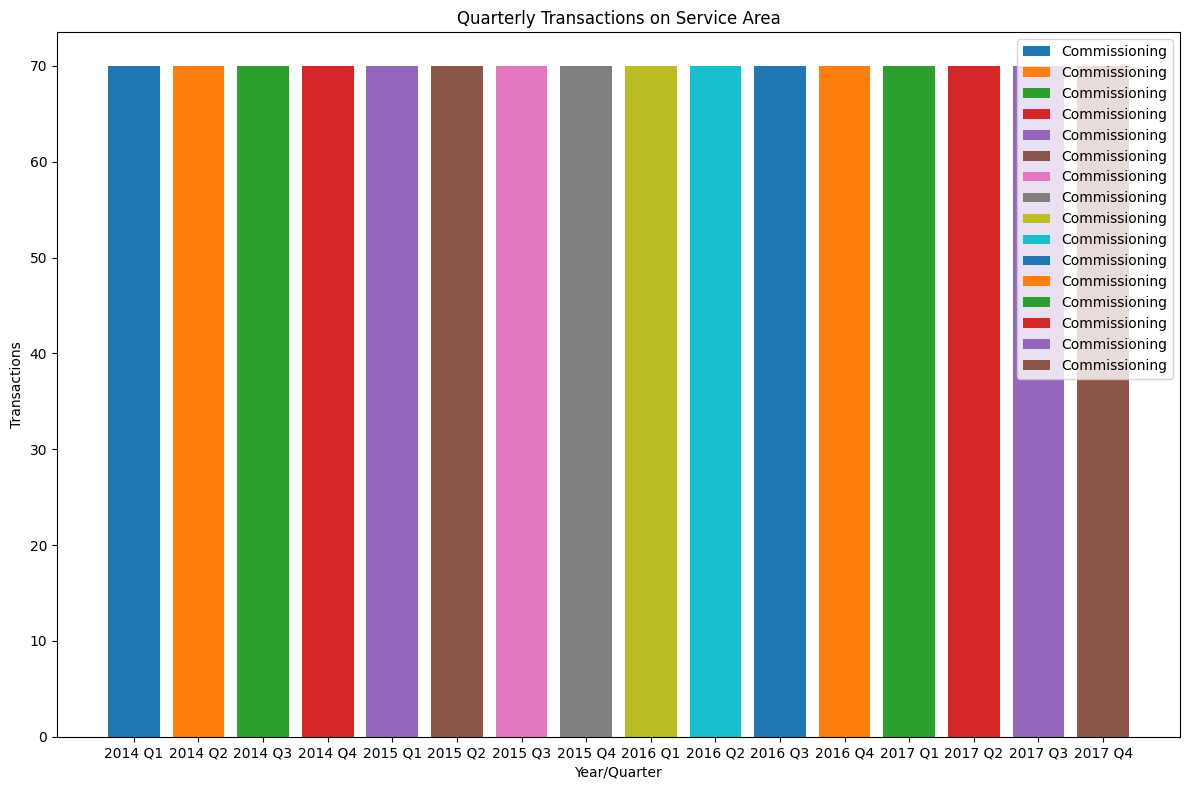

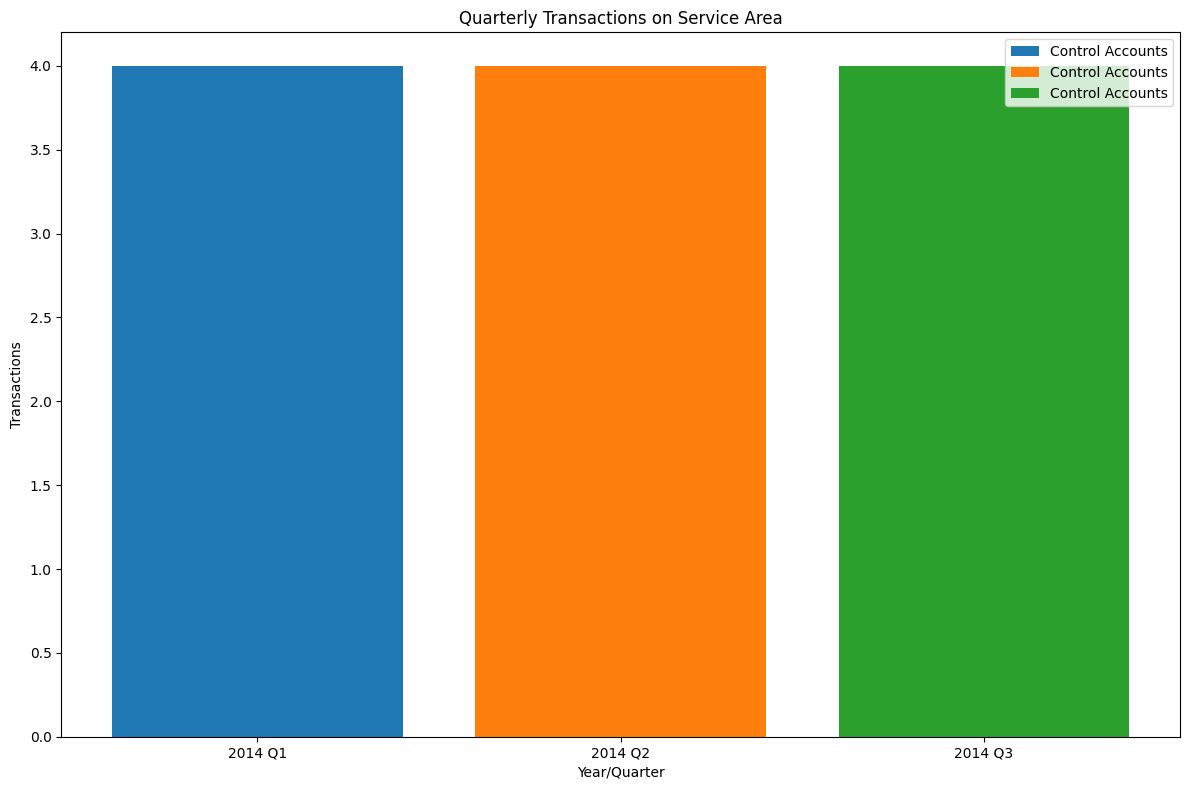

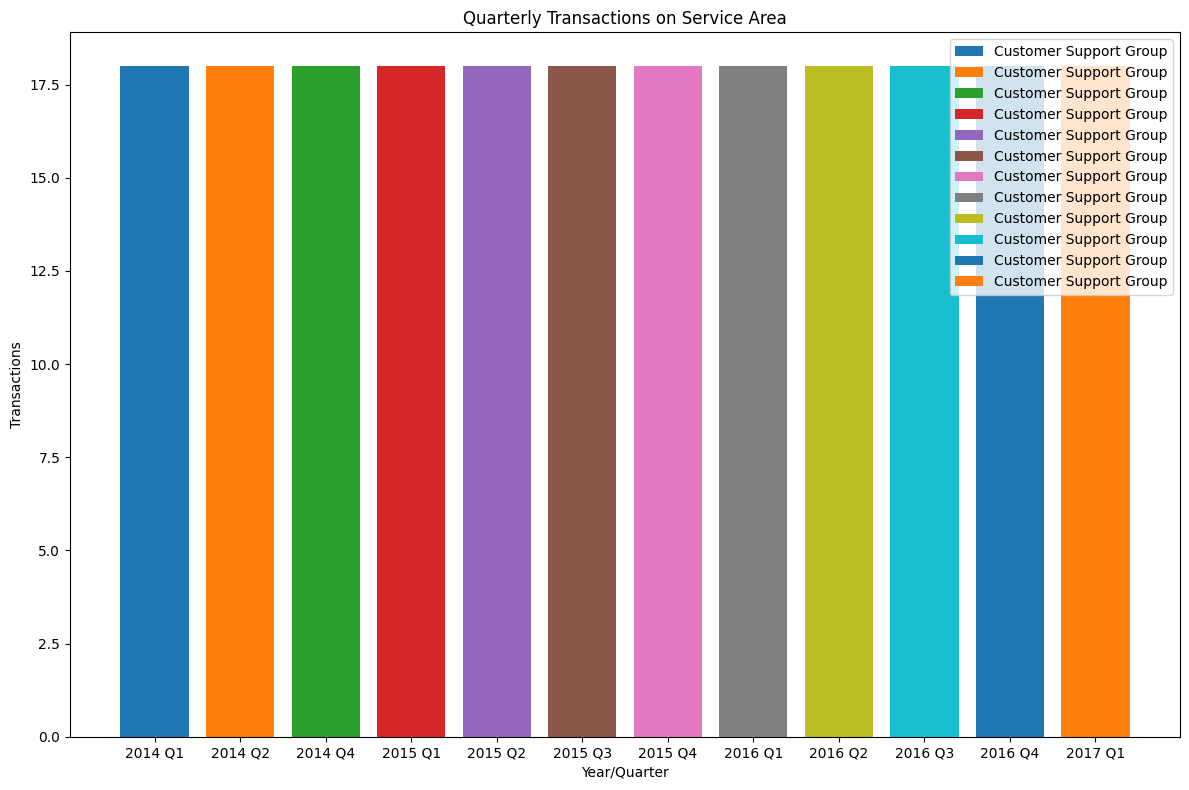

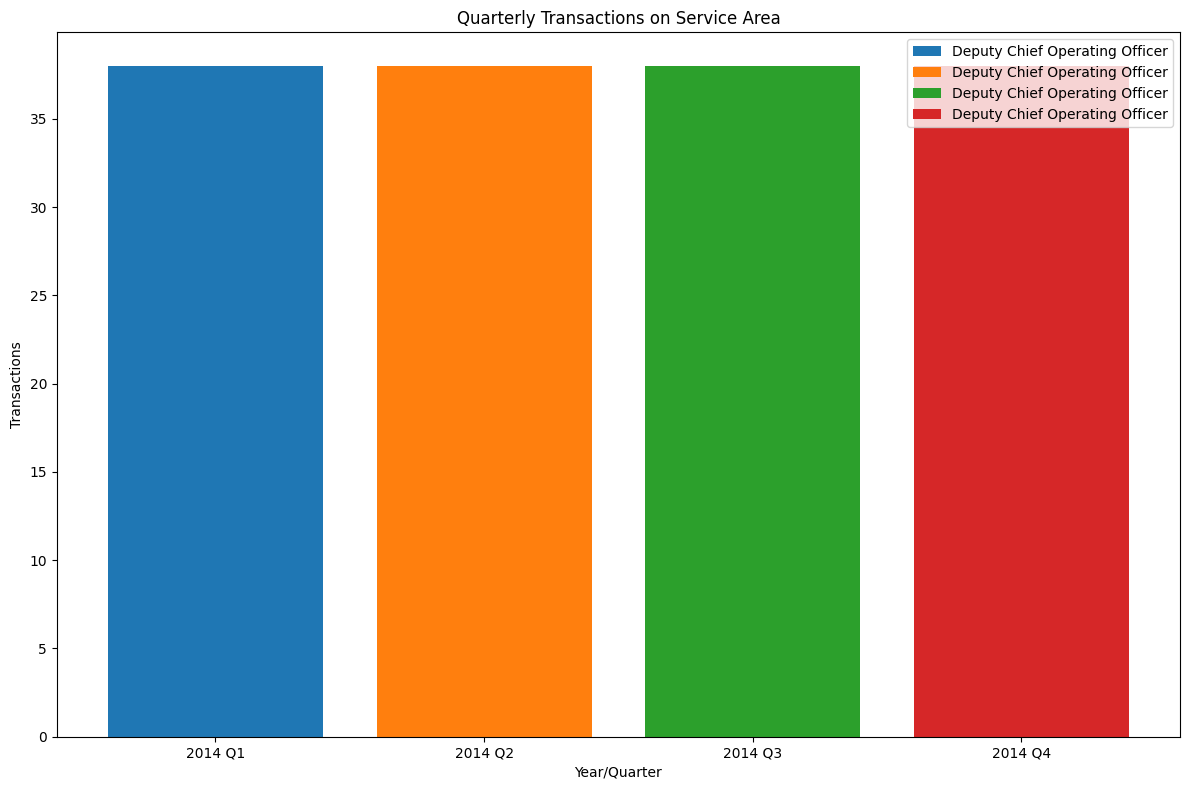

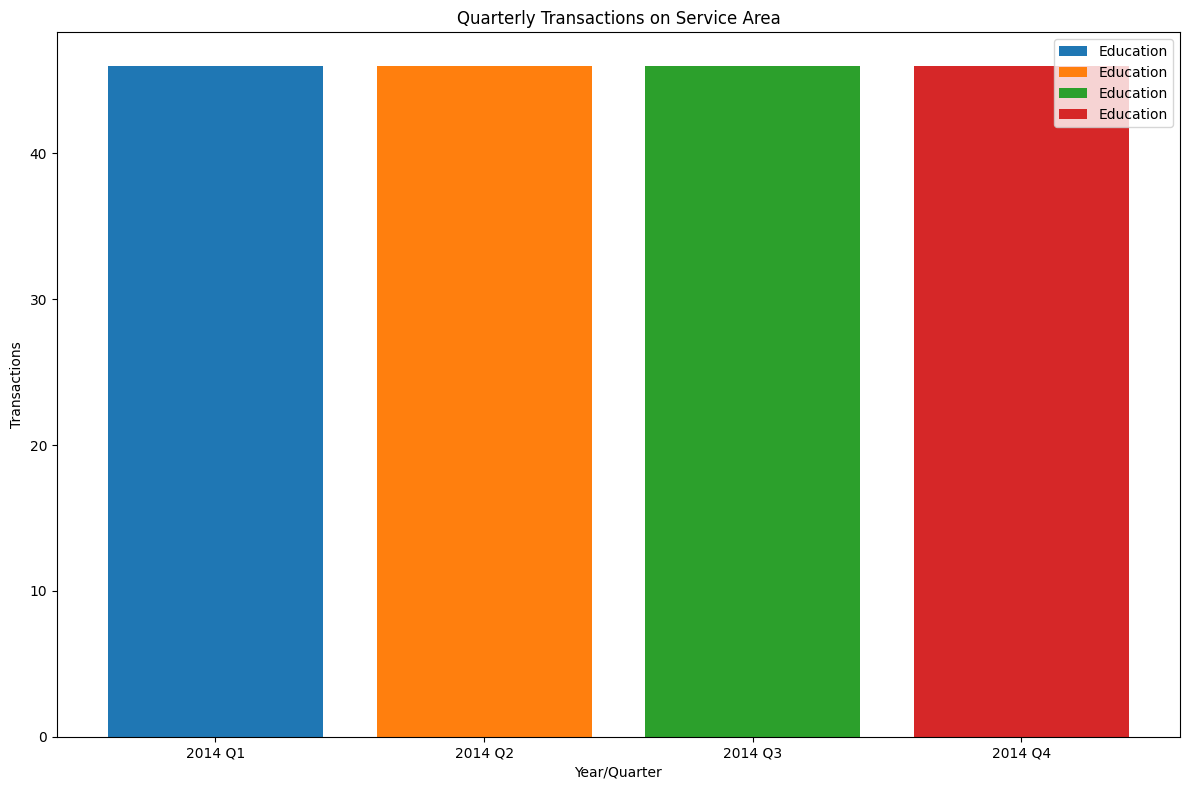

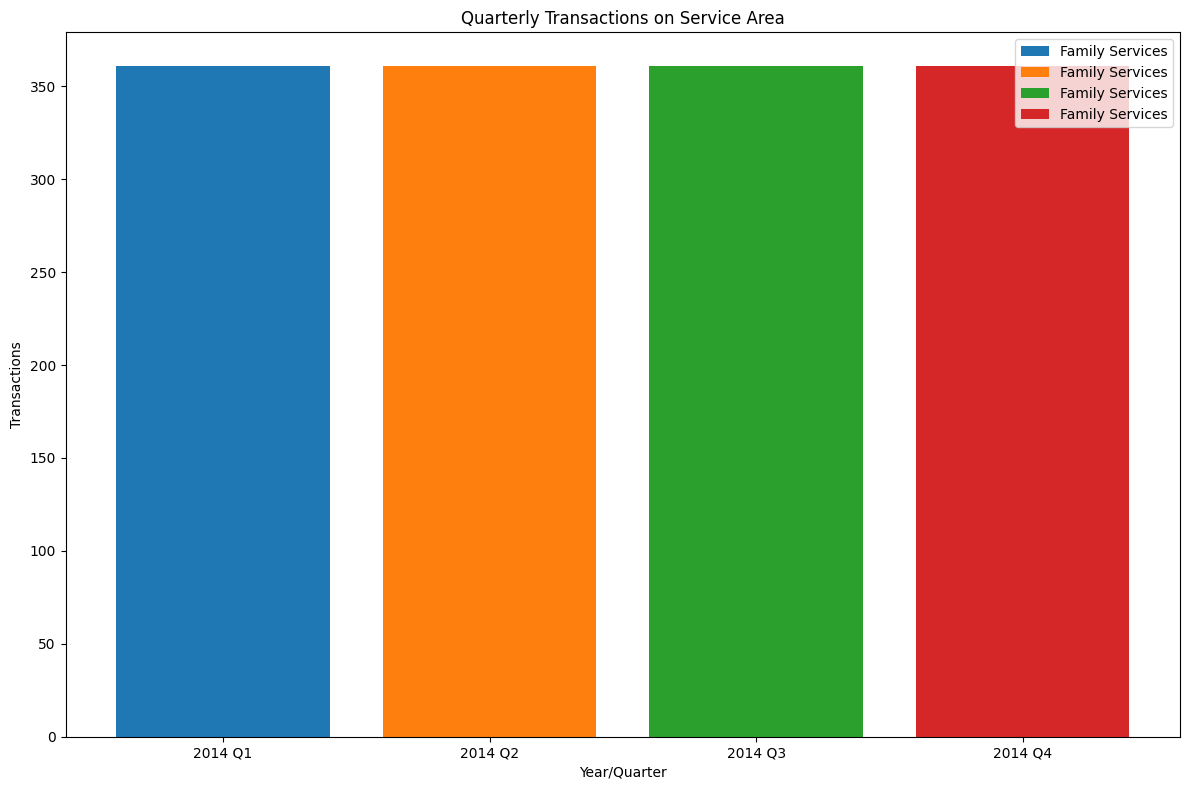

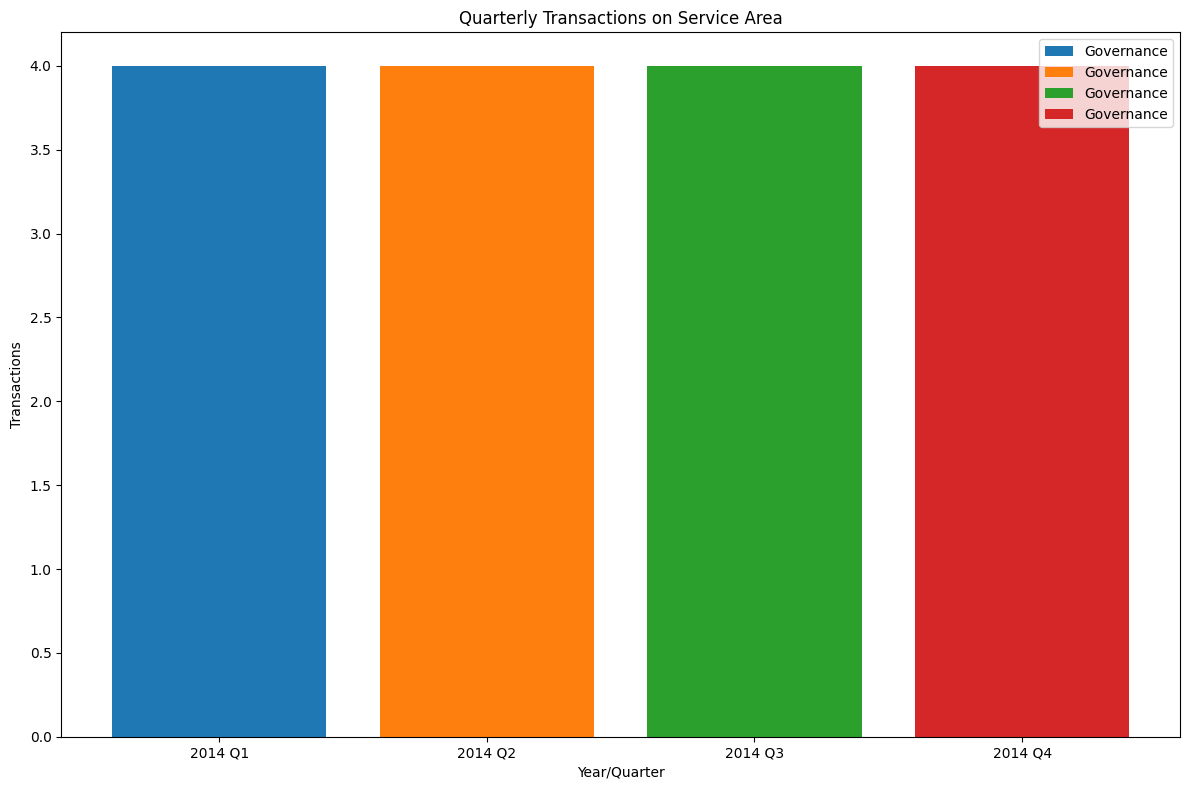

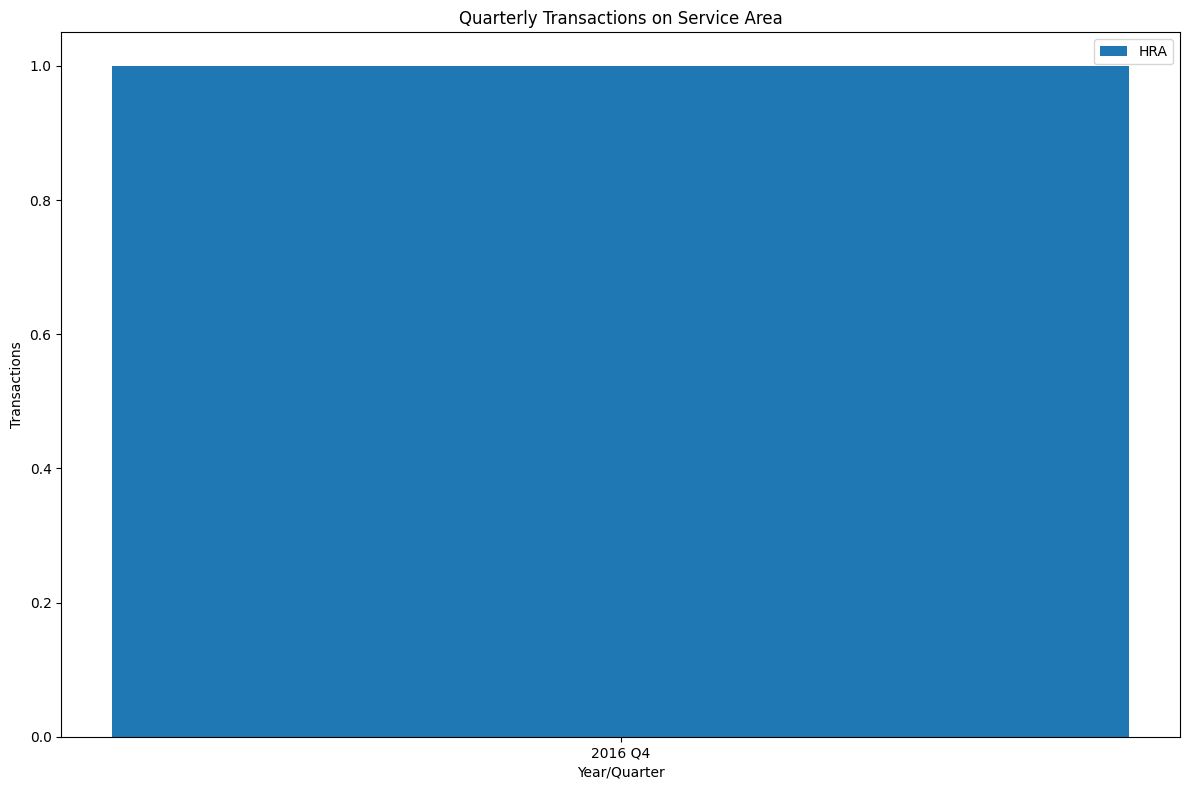

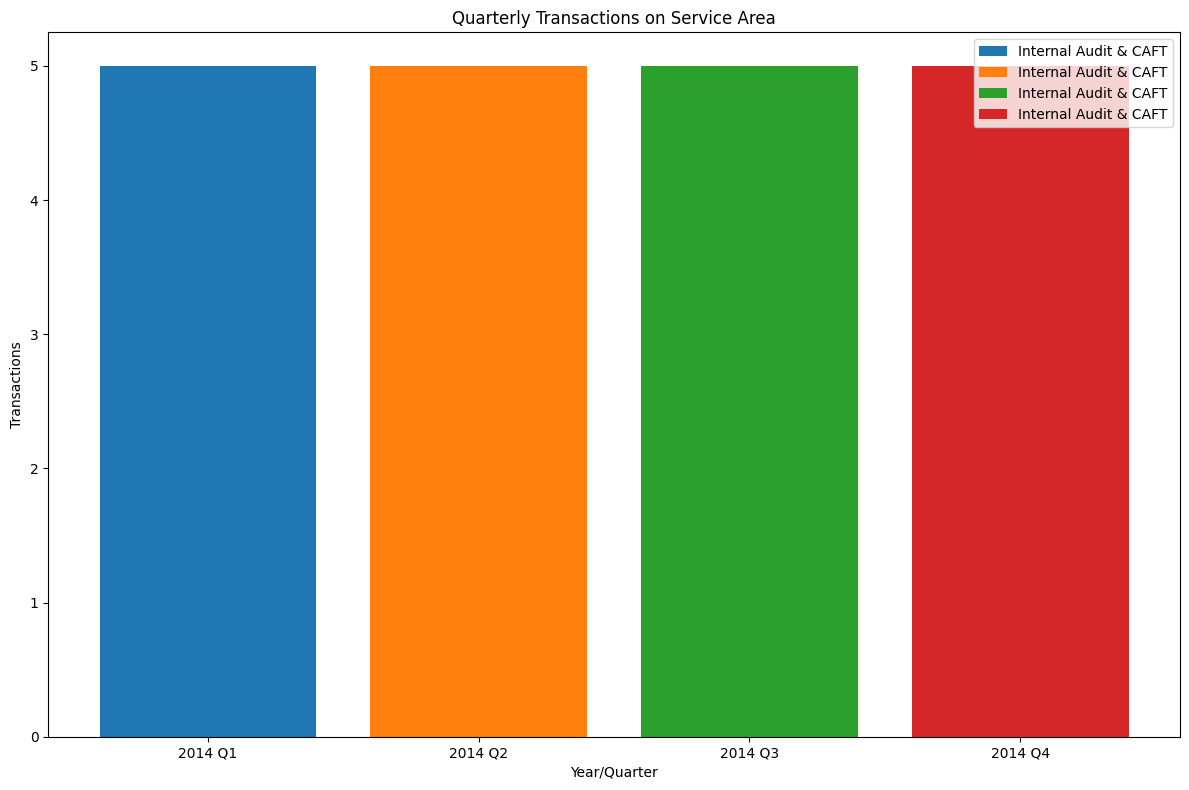

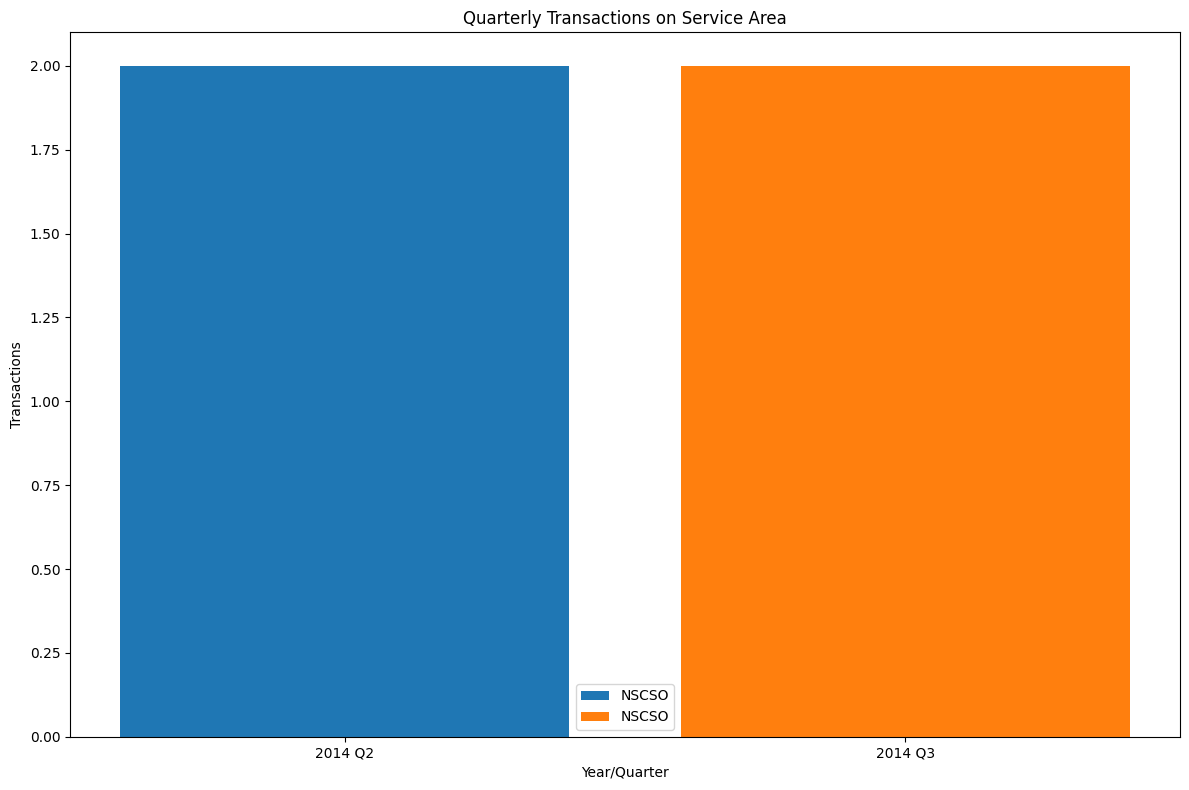

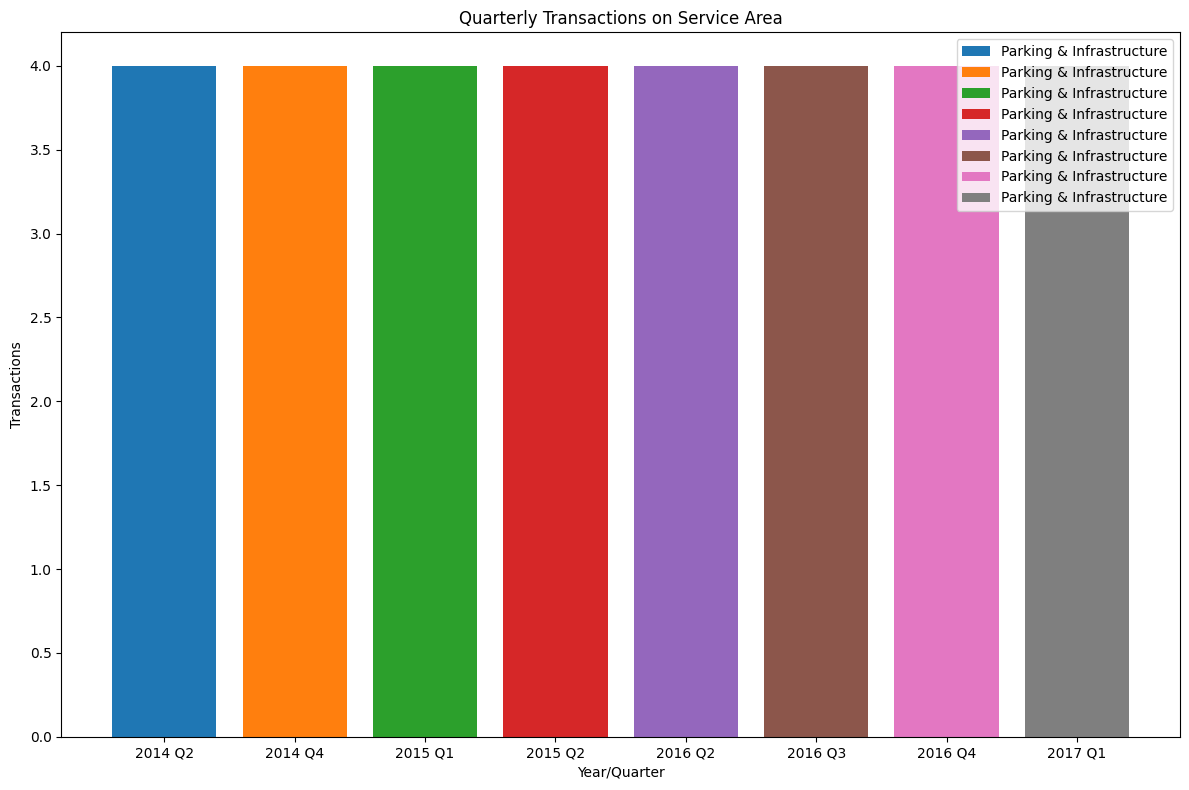

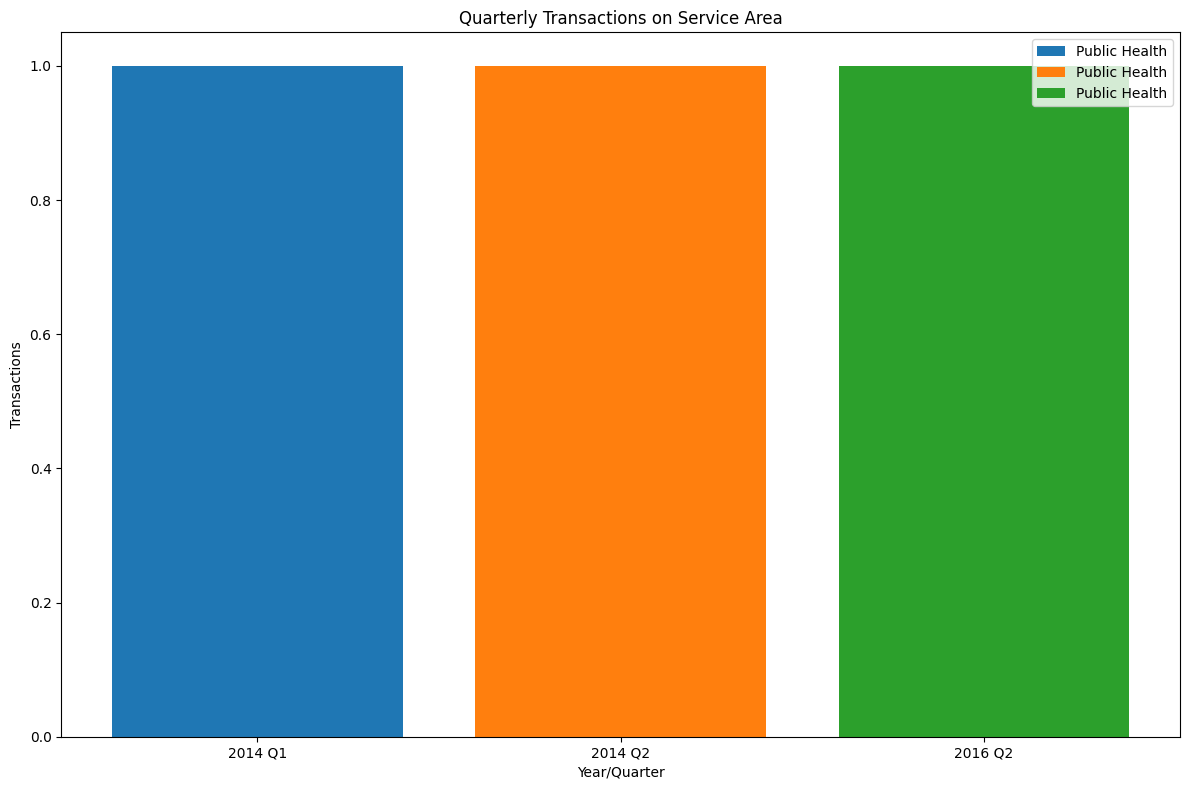

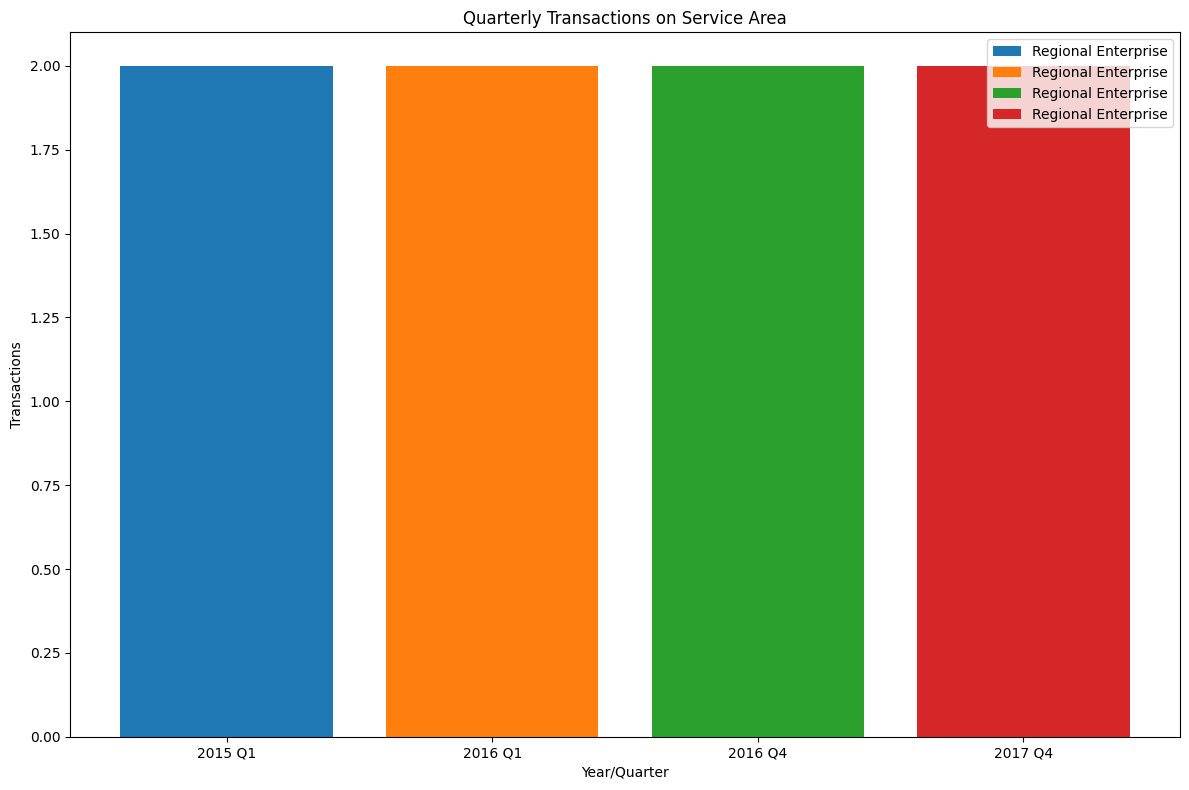

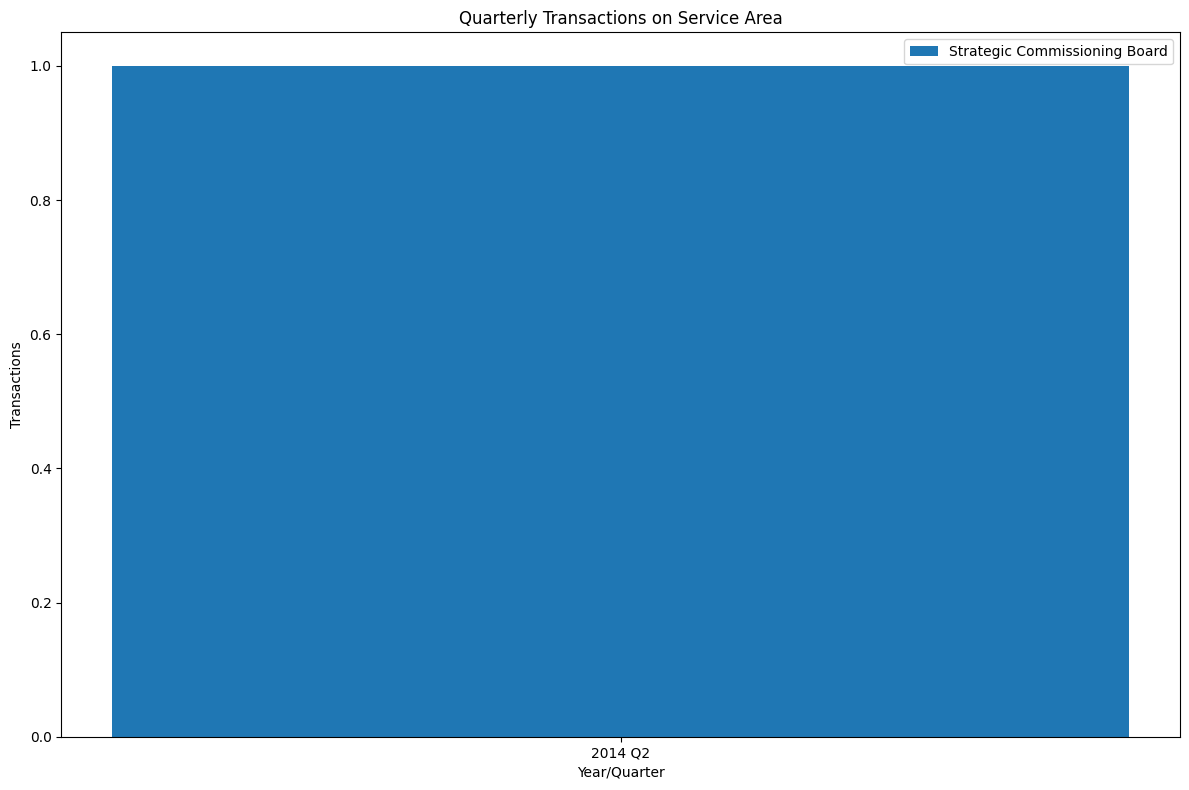

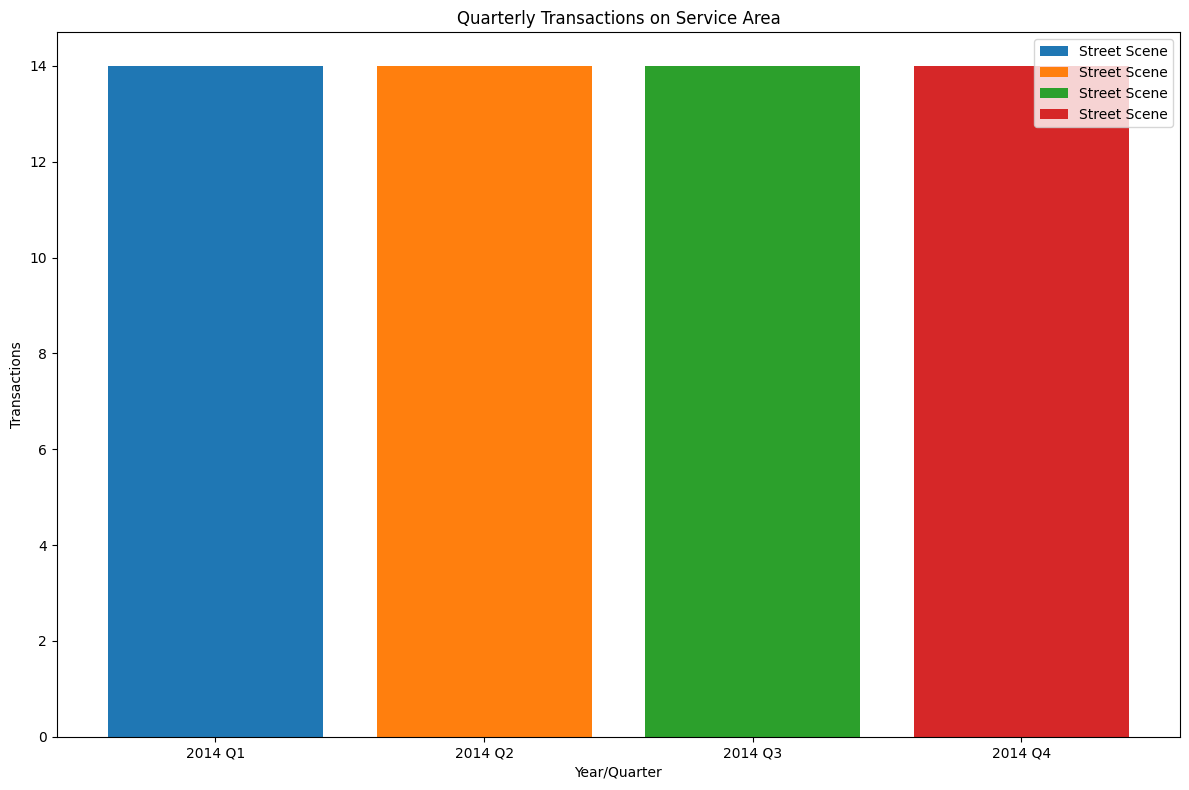

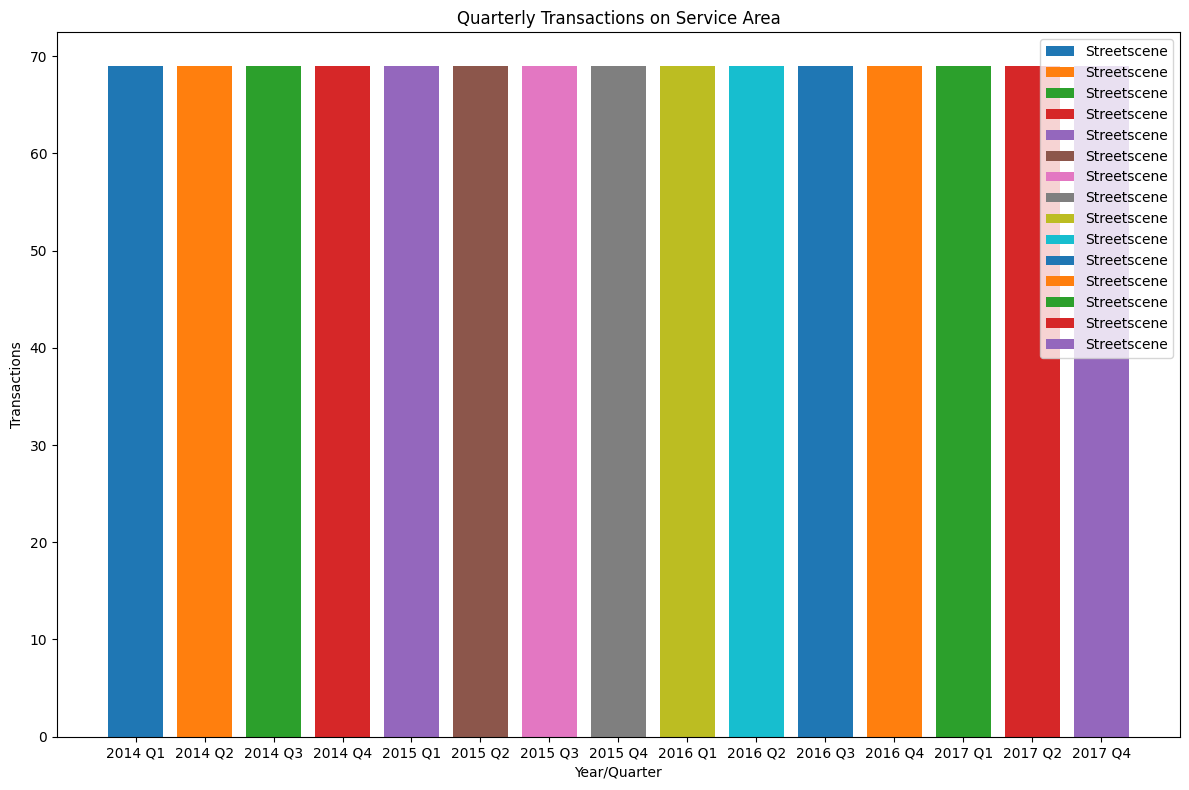

In [68]:
# Create the Visualization.
for areas in transactions['Service Area'].unique():
    areas_data = transactions[transactions['Service Area'] == areas]

    # Chart Resolution: 1280 x 800p
    plt.figure(figsize = (12, 8))
    
    for quarter in areas_data.quarter:
        plt.bar(quarter.strftime('%Y Q%q'), areas_data.total_count, label = areas)
    
    # Chart Decoration.
    plt.legend()

    plt.xlabel('Year/Quarter')
    plt.ylabel('Transactions')

    plt.title('Quarterly Transactions on Service Area')

    plt.tight_layout()

    plt.show()

In [ ]:
# Create the Visualization.
for quarter in transactions.quarter.unique():
    areas_data = transactions[transactions['Service Area'] == areas]

    # Chart Resolution: 1280 x 800p
    plt.figure(figsize = (12, 8))
    
    for quarter in areas_data.quarter:
        plt.bar(quarter.strftime('%Y Q%q'), areas_data.total_count, label = areas)
    
    # Chart Decoration.
    plt.legend()

    plt.xlabel('Year/Quarter')
    plt.ylabel('Transactions')

    plt.title('Quarterly Transactions on Service Area')

    plt.tight_layout()

    plt.show()

- 

In [43]:
# Preparing Data for Visualization.
unique_years = pcd.dataset.quarter.dt.year.unique()
unique_quarters = pcd.dataset.quarter.dt.quarter.unique()

## Bar Charts Per Quarter.

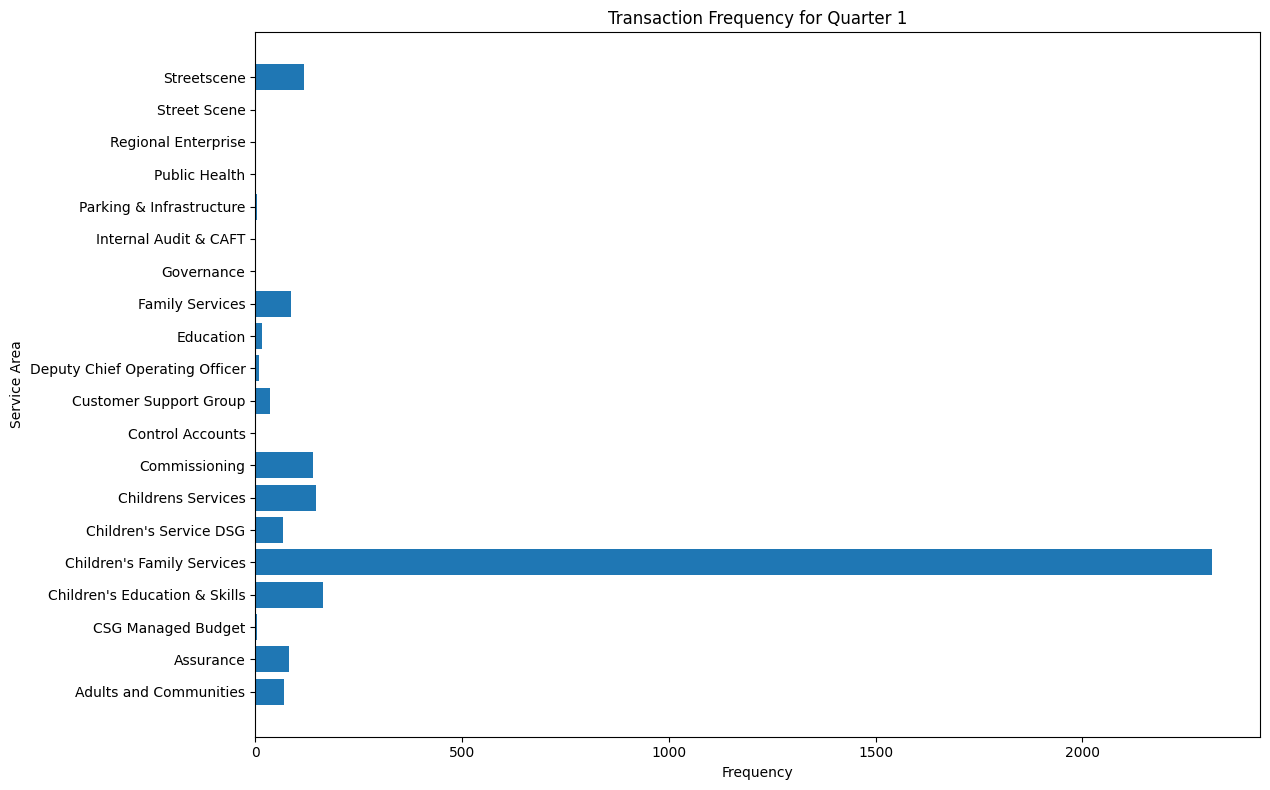

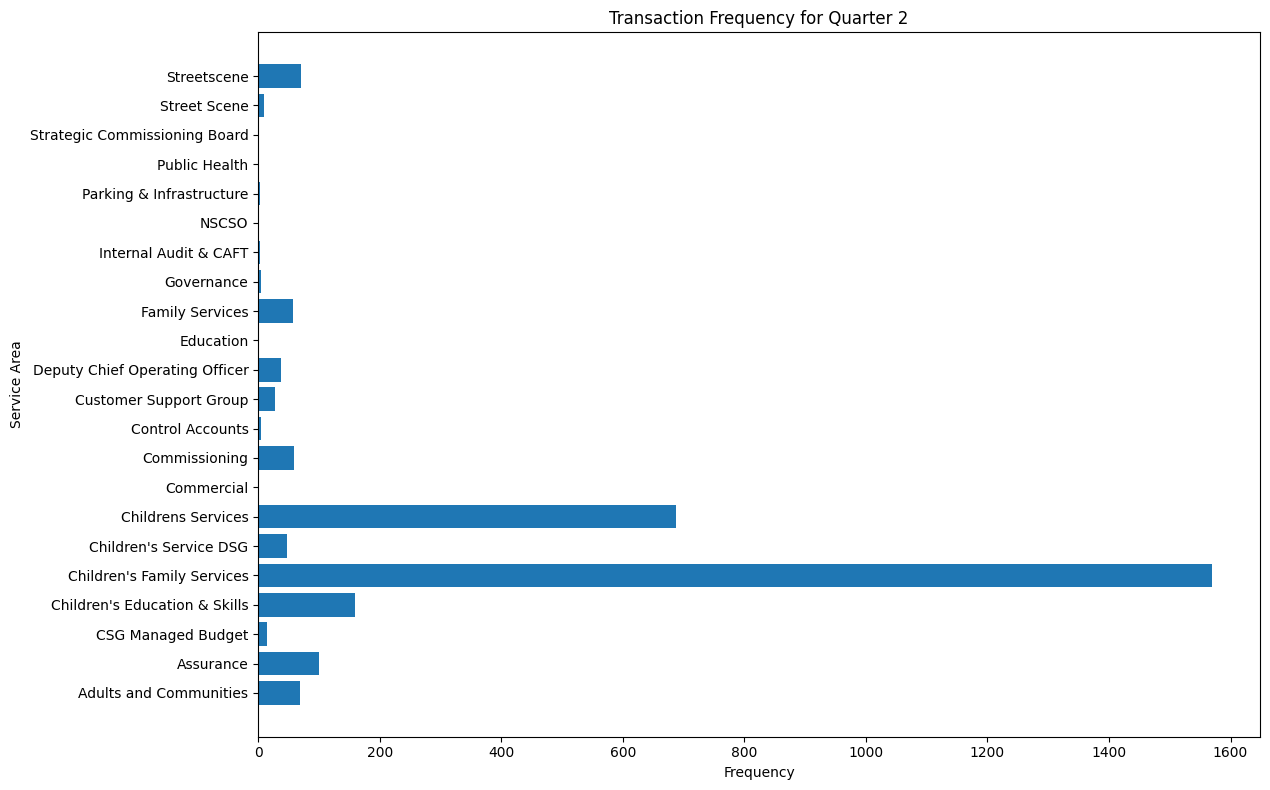

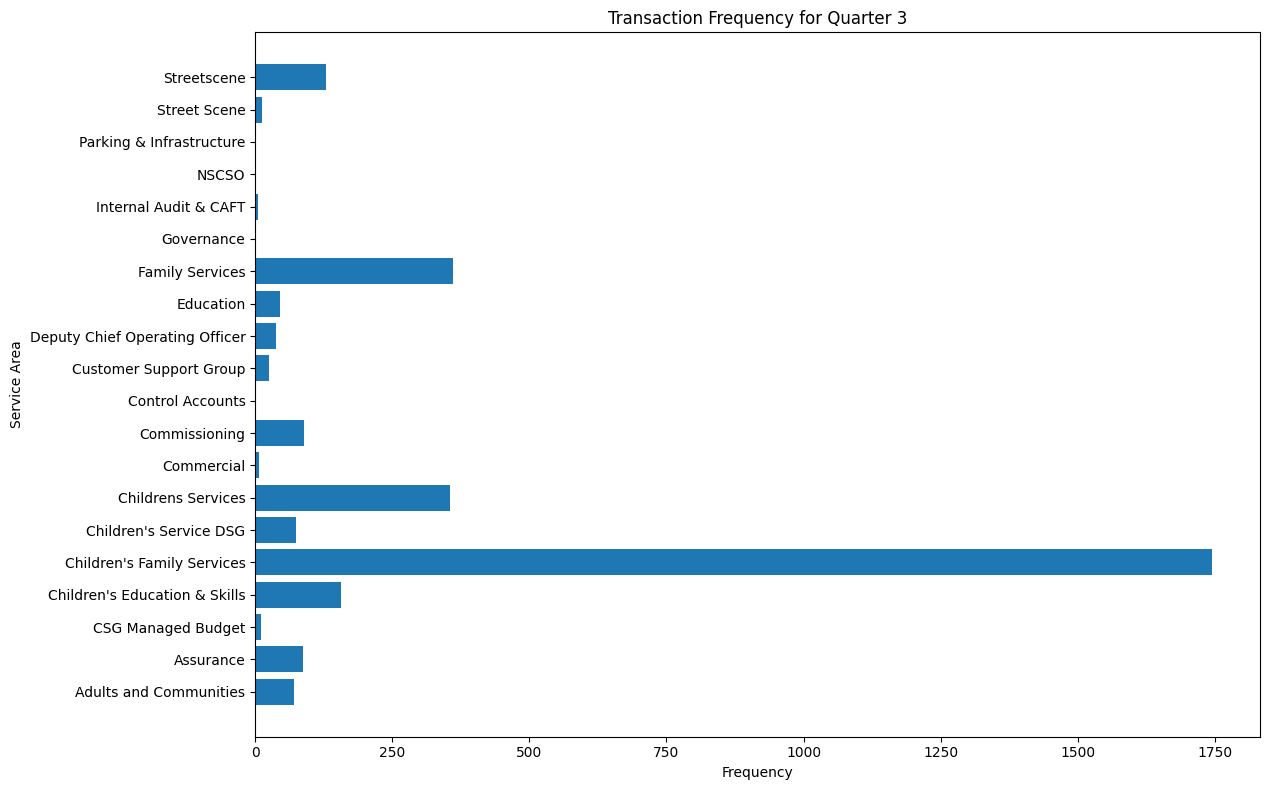

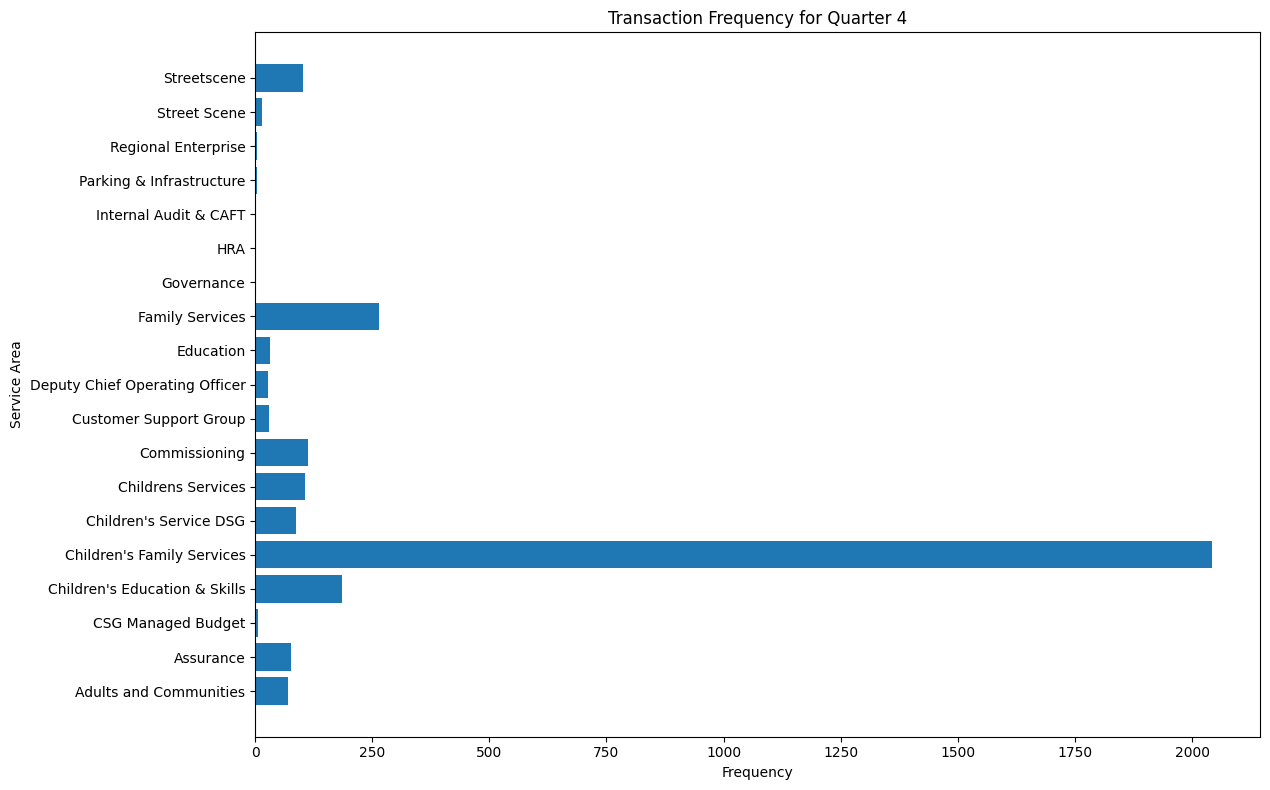

In [44]:
# Plotting Pie Charts.
for iteration, quarter in enumerate(transactions.quarter.dt.quarter.unique()):
    data = transactions[transactions.quarter.dt.quarter == quarter]
    transactions_data = data.groupby('Service Area').transaction_count.sum()
    
    # Chart Resolution: 1280 x 800p
    plt.figure(figsize = (12.8, 8))

    plt.barh(transactions_data.index, transactions_data)
    
    # Chart Decoration.
    plt.xlabel('Frequency')
    plt.ylabel('Service Area')
    
    plt.title('Transaction Frequency for Quarter {}'.format(quarter))

    # Displaying the Chart.
    plt.tight_layout()
    plt.show()

## 2. Behavior of Spendings.
The Auditor would like to get a view if there are any significant changes in spending behavior by Service Area and by Account. Changes in behavior could be spikes, but could also be permanent increases in the transaction amounts. Please identify instances of both or show that they do not exist in the data.

In [69]:
pcd.dataset['amount_change_percentage'] = pcd.dataset.groupby(['Service Area', 'Account Description'])['Journal Value'].pct_change()
pcd.dataset.amount_change_percentage
huge_changes = pcd.dataset[(pcd.dataset.amount_change_percentage > 0.5) | (pcd.dataset.amount_change_percentage < -0.5)]
huge_changes

KeyError: 'Column not found: Journal Value'

In [51]:
#region Data Preparation - Question 2

pcd.dataset['Year'] = pcd.dataset['Transaction Date'].dt.year
yearly_service_area = pcd.dataset.groupby(['Service Area', 'Year']).Total.sum().reset_index()

#endregion

In [52]:
yearly_service_area.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Service Area  54 non-null     object 
 1   Year          54 non-null     float64
 2   Total         54 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.4+ KB


- Need to convert `Year` from float to string.

In [53]:
yearly_service_area.Year = yearly_service_area.Year.astype(str)
yearly_service_area.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Service Area  54 non-null     object 
 1   Year          54 non-null     object 
 2   Total         54 non-null     float64
dtypes: float64(1), object(2)
memory usage: 1.4+ KB


In [55]:
# Removing Null Values.
yearly_service_area.dropna(subset = ['Change in percentage'])

KeyError: ['Change in percentage']

## 3. Classification of Creditors into Accounts.
The Auditor would like to get an understanding of how Creditors are classified into accounts. In particular, they are worried about transaction misclassification. Are you able to identify instances in which Creditors are not consistently classified into Accounts (e.g., most of the time Creditor “AirTickets.com” is classified into “Travelling Expenses”, but on some occasions it is also found in “Miscellaneous”)?

In [72]:
# Grouping creditors with accounts.
creditors_count = pcd.dataset.groupby(['Creditor', 'Account Description']).size().reset_index(name = 'Count')
creditors_count

,Creditor,Account Description,Count
0,ARGOS,Other Transfer Payments to Soc,1
1,COFFEE REPUBLIC WOO,Food Costs,1
2,COSTCUTTER,Food Costs,1
3,H HARIA CHEMIST,Other Transfer Payments to Soc,1
4,LEWISS,Equipment and Materials Purcha,1
...,...,...,...
2870,ZAHRA NEWSAGENT,Books-CDs-Audio-Video,1
2871,ZAHRA NEWSAGENT,Food Costs,13
2872,ZIZZI CENTRAL ST,Training,1
2873,amazonpayments.co.u,Private Contractors - Third Pa,2


In [73]:
# Identifying `Creditors` being classified into various `Account Description`.
creditors_classifications = creditors_count[creditors_count.duplicated(subset = 'Creditor', keep = False)]
creditors_classifications

,Creditor,Account Description,Count
15,123-REG.CO.UK,IT Services,1
16,123-REG.CO.UK,Subscriptions,1
22,99P STORES LTD,E19 - Learning Resources,1
23,99P STORES LTD,Equipment and Materials Purcha,2
25,A&Y LOCKSMITHS,Clothing - Protective Clothing,1
...,...,...,...
2859,WWW.YELLOWMOON.ORG.UK,Other Services,1
2861,WWW.ZATPAY.COM,IT Services,1
2862,WWW.ZATPAY.COM,Other Services,2
2870,ZAHRA NEWSAGENT,Books-CDs-Audio-Video,1


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

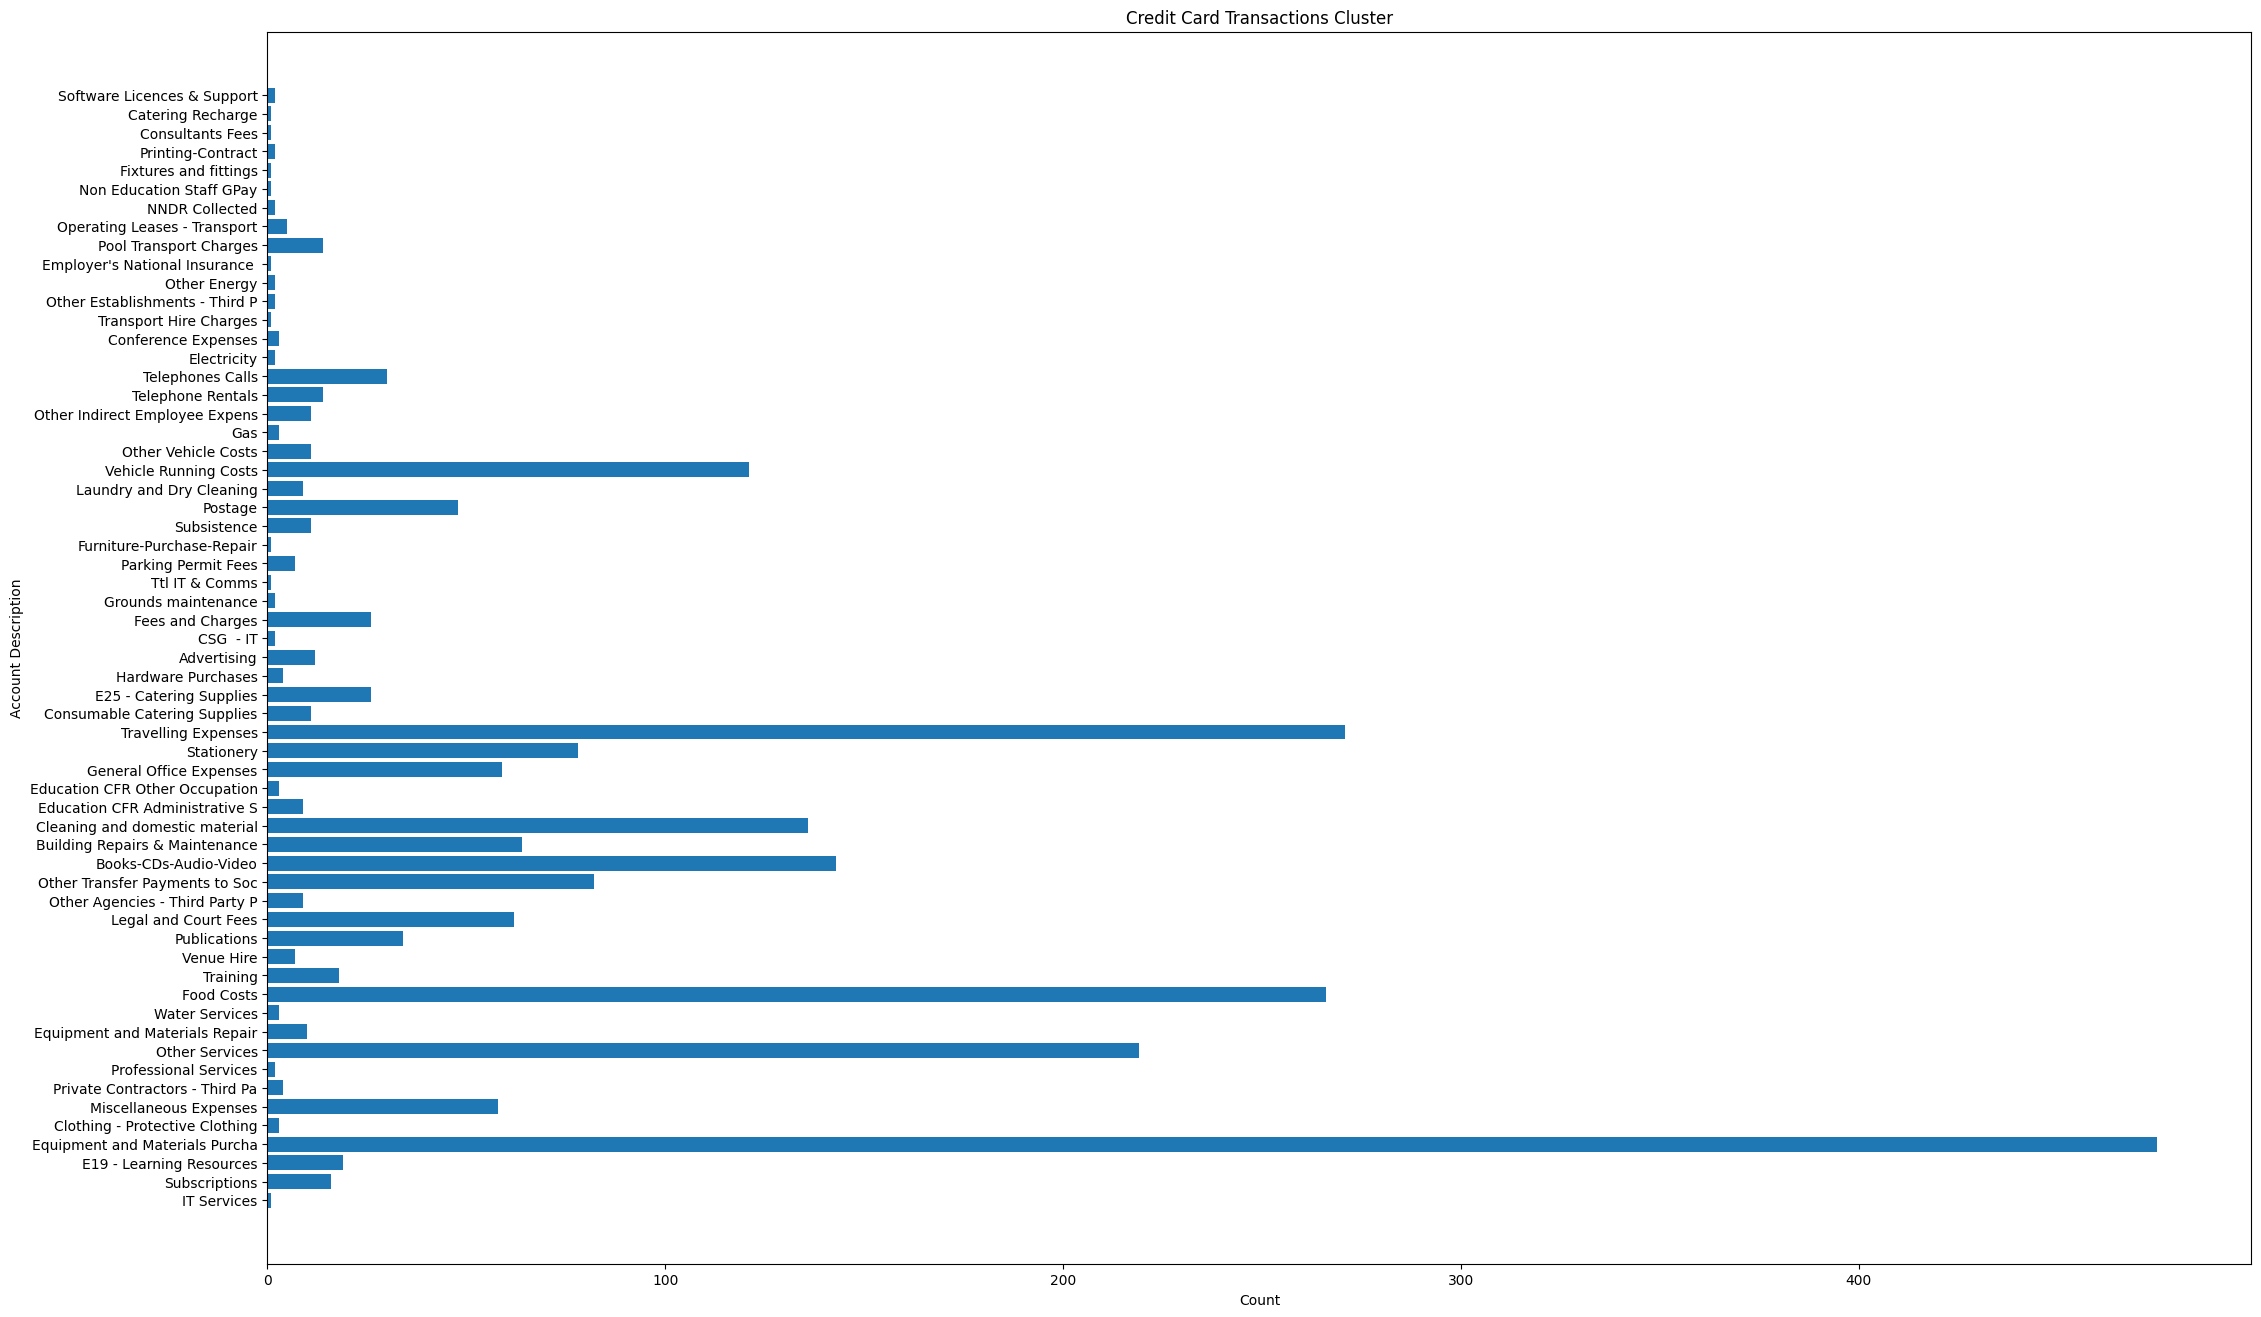

In [74]:
# Chart Resolution: 2560 x 1600p
plt.figure(figsize = (25.6, 16))

# Plotting Clusters.
# plt.scatter(creditors_classifications.Creditor,
#             creditors_classifications['Account Description'],
#             c = creditors_classifications.Count,
#             cmap = 'viridis',
#             marker = '*')
plt.barh(creditors_classifications['Account Description'],
         creditors_classifications.Count)

# Chart Decoration.
plt.xlabel('Count')
plt.ylabel('Account Description')

plt.title('Credit Card Transactions Cluster')

plt.colorbar(label = 'Cluster')

# Displaying the Chart.
plt.show()

## 4. 
In terms of spending behavior (defined by the number and the typical size of transactions), are there Service Areas that behave similarly and can be grouped together? How?

## 5.
The auditor has heard that you may know anomaly detection techniques. They would like to ask you for a sample of a few hundred transactions that are anomalous, different or worthwhile inquiring about.  The sample should include at least five transactions for each Service Area. Please provide this sample and explain why they are special or different.

In [75]:
isolation_forest = IsolationForest(contamination = 0.05, random_state = 42)

In [77]:
isolation_forest.fit([pcd.dataset.Total])

IsolationForest(contamination=0.05, random_state=42)

In [79]:
pcd.dataset['Anomaly'] = isolation_forest.predict([pcd.dataset.Total])

ValueError: Length of values (1) does not match length of index (17520)

In [80]:
abnormal_transactions = pcd.dataset[pcd.dataset.Anamoly == -1].sample(n = 500, random_state = 42)
abnormal_transactions

AttributeError: 'DataFrame' object has no attribute 'Anamoly'